# DATA

# Import

### Import Modules

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

### Import Data

In [2]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_pickle('df_10M.pickle')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_pickle('df_B100.pickle')

# unique songs from the Billboard 100 lists, only songs with audio features included
df_B100_songs = pd.read_pickle('df_B100_songs.pickle')

# all unique songs from the Billboard 100 lists, only songs with genre included
df_B100_songs_genre = df_B100_songs.dropna().copy().reset_index(drop=True)

In [3]:
# Popularity (as defined as "has been on the Billboard Hot 100" list)
# now combine, categorise, and correlate datasets

set_B100_id = set(df_B100_songs.id)

temp_not_popular = df_10M[~df_10M.id.isin(set_B100_id)].copy().reset_index(drop=True)
temp_not_popular['POPULAR'] = False

temp_popular = df_B100_songs.copy()
temp_popular['POPULAR'] = True

df_popularity = pd.concat([temp_not_popular, temp_popular]).reset_index(drop=True)

del temp_not_popular
del temp_popular

In [4]:
# import genre count data
df_genre_counts = pd.read_pickle('df_genre.pickle').set_index('genre').rename({'genre_count': 'count'}, axis=1)

# Data Description

### Data Sources

**The Billboard 100**

https://en.wikipedia.org/wiki/Billboard_Hot_100

https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs

**1.2M Songs with Metadata (csv)**

https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs

**8+ M. Spotify Tracks, Genre, Audio Features (SQL)**

https://www.kaggle.com/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features


**Spotify API**

https://developer.spotify.com/documentation/web-api/

https://developer.spotify.com/console/get-search-item

https://developer.spotify.com/console/get-audio-features-track/

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

Spotipy Library:  https://spotipy.readthedocs.io/en/master/


### Data Description and Discussion

* The Billboard 100 data did not include audio features. It was combined with audio features from the following sources:
    * 1.2M Songs with Metadata (csv format)
    * 8+ M. Spotify Tracks, Genre, Audio Features (SQLite format)
    * Spotify API data gathered via the library Spotipy
* Overall, audio features was gathered for approximately 75% of songs from the Billboard 100.
    * Some songs were excluded based on data repetition issues
        * Typically this was only hard to find songs with very similar names
        * For example searching for 'Metallica The Unforgiven' and 'Metallica The Unforgiven Part 2' yielded the same Spotify id
            * It was determined that excluding these songs was less error-prone than manually fixing the issues
            * Alternatively, we could have kept 1 song. In this case, there is up to a 50% chance that the song is mislabelled, so this option appeared less favourable than dropping both repeat instances.
* A Quality Assurance (QA) check was performed on the final dataset.
    * Audio features from 100 songs were gathered from the Spotify API and compared to the datasets listed above.
    * There were 3 non-trivial issues noted in 2 of the 100 songs:
        * Madonna Live To Tell
            * A significant increase in loudness (~7 dB)
            * Approximately 1 second difference in length
            * All other audio features consistent between data sources
            * Both of these changes appear to result from remastering and re-uploading the track
                * https://artists.spotify.com/help/article/re-uploading-music
        * Lil Wayne Let It All Work Out
            * The key signature was not consistent between the 2 sources
            * The newer source (the API request from Sept 11, 2022) was correct (B major)
            * The SQL database was also different
            * My supposition is that these errors are due to the characteristics of the song:
                * atonal (most notably the singing)
                * detuned (bass pitch automation, and low-fi detuning effects)
    * Overall, there is a large degree of consistency between datasets. Furthermore, inconsistencies are all explainable with reasonable suppositions.

### Spotify API Audio Feature Descriptions
from: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

##### acousticness
number
\<float>

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

    >= 0
    <= 1

##### analysis_url
string

A URL to access the full audio analysis of this track. An access token is required to access this data.

##### danceability
number
\<float>

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

##### duration_ms
integer

The duration of the track in milliseconds.

##### energy
number
\<float>

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

##### id
string

The Spotify ID for the track.

##### instrumentalness
number
\<float>

Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

##### key
integer
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

    >= -1
    <= 11

##### liveness
number
\<float>

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

##### loudness
number
\<float>

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

##### mode
integer

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

##### speechiness
number
\<float>

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

##### tempo
number
\<float>

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

##### time_signature
integer

An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

    >= 3
    <= 7

##### track_href
string

A link to the Web API endpoint providing full details of the track.

##### type
string

The object type.

Allowed value:
"audio_features"

##### uri
string

The Spotify URI for the track.

##### valence
number
\<float>

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

    >= 0
    <= 1

### Descriptive Statistics and Data Features

In [5]:
# sizes of the datasets
df_10M.shape, df_B100.shape, df_B100_songs.shape, df_B100_songs_genre.shape

((9431755, 19), (330087, 23), (21274, 18), (19750, 18))

In [6]:
# are any keys unknown (key == -1)
sorted(df_B100_songs['key'].unique()), sorted(df_10M['key'].unique())
# no

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [7]:
# data types
pd.concat(
    [df_10M.dtypes, df_B100.dtypes, df_B100_songs.dtypes], 
    keys=['df_10M.dtypes', 'df_B100.dtypes', 'df_B100_songs.dtypes'],
    axis=1
)

,df_10M.dtypes,df_B100.dtypes,df_B100_songs.dtypes
id,object,object,object
song,object,object,object
artist,object,object,object
genre,object,object,object
release_date,datetime64[ns],datetime64[ns],datetime64[ns]
acousticness,float32,float32,float32
danceability,float32,float32,float32
duration_ms,Int64,Int64,Int64
energy,float32,float32,float32
instrumentalness,float32,float32,float32


In [8]:
# Date Range for Billboard Hot 100

df_B100.date.min(), df_B100.date.max()

(Timestamp('1958-08-04 00:00:00'), Timestamp('2021-11-06 00:00:00'))

In [9]:
df_10M.describe().loc['mean':'max'].T

,mean,std,min,25%,50%,75%,max
acousticness,0.422,0.373,0.000,0.033,0.337,0.819,0.996
danceability,0.527,0.191,0.000,0.395,0.544,0.675,1.000
duration_ms,238311.970,156917.572,1000.000,169587.000,216933.000,275400.000,6072187.000
energy,0.545,0.282,0.000,0.309,0.566,0.789,1.000
instrumentalness,0.260,0.375,0.000,0.000,0.002,0.657,1.000
key,5.238,3.542,0.000,2.000,5.000,8.000,11.000
liveness,0.209,0.180,0.000,0.096,0.129,0.262,1.000
loudness,-10.997,6.339,-60.000,-13.723,-9.208,-6.401,7.234
mode,0.661,0.473,0.000,0.000,1.000,1.000,1.000
speechiness,0.098,0.136,0.000,0.036,0.047,0.083,0.974


In [10]:
df_B100.describe().loc['mean':'max'].T

,mean,std,min,25%,50%,75%,max
rank,50.501,28.866,1.000,26.000,51.000,76.000,100.000
last-week,47.592,28.054,1.000,23.000,47.000,72.000,100.000
peak-rank,40.971,29.347,1.000,13.000,38.000,65.000,100.000
weeks-on-board,9.162,7.618,1.000,4.000,7.000,13.000,90.000
acousticness,0.278,0.275,0.000,0.041,0.178,0.467,0.995
danceability,0.601,0.149,0.000,0.505,0.610,0.706,0.988
duration_ms,226926.400,65973.000,37013.000,183560.000,221400.000,258533.000,1292293.000
energy,0.626,0.198,0.018,0.482,0.644,0.787,0.996
instrumentalness,0.031,0.133,0.000,0.000,0.000,0.001,0.985
key,5.220,3.560,0.000,2.000,5.000,8.000,11.000


In [11]:
df_B100_songs.describe().loc['mean':'max'].T

,mean,std,min,25%,50%,75%,max
acousticness,0.316,0.290,0.000,0.053,0.224,0.555,0.995
danceability,0.589,0.152,0.000,0.490,0.597,0.697,0.988
duration_ms,217614.286,67767.959,37013.000,169707.000,210533.000,251260.250,1292293.000
energy,0.611,0.203,0.018,0.464,0.625,0.775,0.996
instrumentalness,0.036,0.144,0.000,0.000,0.000,0.001,0.985
key,5.198,3.553,0.000,2.000,5.000,8.000,11.000
liveness,0.194,0.163,0.015,0.091,0.131,0.250,0.999
loudness,-8.904,3.615,-29.519,-11.323,-8.524,-6.079,2.291
mode,0.743,0.437,0.000,0.000,1.000,1.000,1.000
speechiness,0.066,0.075,0.000,0.032,0.040,0.061,0.941


In [12]:
df_B100_songs_genre.describe().loc['mean':'max'].T

,mean,std,min,25%,50%,75%,max
acousticness,0.309,0.288,0.000,0.051,0.215,0.539,0.995
danceability,0.589,0.152,0.000,0.491,0.597,0.697,0.988
duration_ms,219136.535,67455.535,37013.000,171881.250,212027.000,252236.750,1292293.000
energy,0.613,0.202,0.018,0.465,0.626,0.776,0.996
instrumentalness,0.033,0.135,0.000,0.000,0.000,0.001,0.985
key,5.206,3.556,0.000,2.000,5.000,8.000,11.000
liveness,0.193,0.162,0.015,0.091,0.131,0.249,0.999
loudness,-8.840,3.613,-29.029,-11.269,-8.433,-6.003,-0.380
mode,0.741,0.438,0.000,0.000,1.000,1.000,1.000
speechiness,0.067,0.075,0.000,0.032,0.040,0.061,0.941


In [13]:
# Genre Counts

# percentage of songs with audio features that also have genre data
# NOTE: not all songs on Spotify have an associated genre
df_B100.groupby(['song', 'artist']).count().shape[0], df_B100_songs.shape[0], df_B100_songs_genre.shape[0]

# all, AF, genre

(29681, 21274, 19750)

In [14]:
# number of total songs which include audio features with and without genre 
df_10M.genre.count(), df_10M.shape[0], df_10M.genre.count() / df_10M.shape[0]

(6320843, 9431755, 0.6701661567757008)

**Proportion of Songs With Audio Feature Data:**

~75% of songs on the Billboard list are available on Spotify, and weren't removed for data errors

In [15]:
# All Billboard 100 lists
(
    df_B100[df_B100.id.notnull()].shape[0], 
    df_B100.shape[0], 
    df_B100[df_B100.id.notnull()].shape[0] / df_B100.shape[0]
)
# number not null, total, proportion not null

(243051, 330087, 0.7363240600205401)

In [16]:
# All songs from Billboard 100 lists
(
    df_B100_songs.shape[0], 
    df_B100.groupby(['song', 'artist']).count().shape[0], 
    df_B100_songs.shape[0] / df_B100.groupby(['song', 'artist']).count().shape[0]
)
# number not null, total, proportion not null

(21274, 29681, 0.716754826319868)

# EXPLORATORY DATA ANALYSIS

# Histograms

In [17]:
# main features
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

def compare_histograms(feature, bins=50, logy=False, figsize=(16, 6)):
    
    plt.figure(figsize=figsize)
    
    # bins don't line up unless you do this
    if feature == 'loudness':
        xmin, xmax = -16, 0
        plt.xlim(xmin, xmax)  # reasonable range for loudness in music
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    elif feature == 'tempo':
        xmin, xmax = 40, 200
        plt.xlim(xmin, xmax)  # reasonable range for tempo in music
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    else:
        xmin, xmax = 0, 1
        plt.xlim(xmin, xmax)  # most audio features vary between 0 and 1
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]         
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
    # plots
    plt.hist(df_B100_songs[feature], bins_plot, alpha=0.5, label='Hot 100 Songs', density=True)
    plt.hist(df_10M[feature], bins_plot, alpha=0.5, label='All Songs', density=True)
    
    title = f'{feature.title()} Histogram'
#     plt.title(title)
    plt.xlabel(feature.title().replace('_', ' '))
    plt.legend(loc='upper right')
    if logy:
        plt.yscale('log')
        plt.ylabel('Log Relative Frequency')
    else:
        plt.ylabel('Relative Frequency')
    
    # save the image
    plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)
    
    plt.show()


Acousticness Histogram


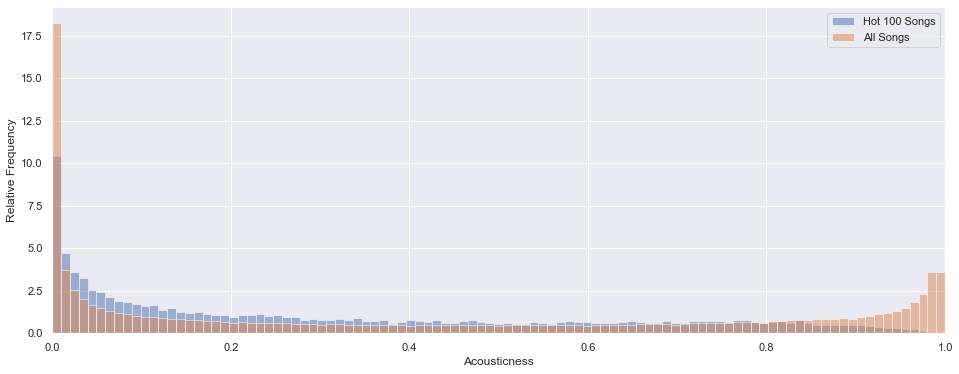

Danceability Histogram


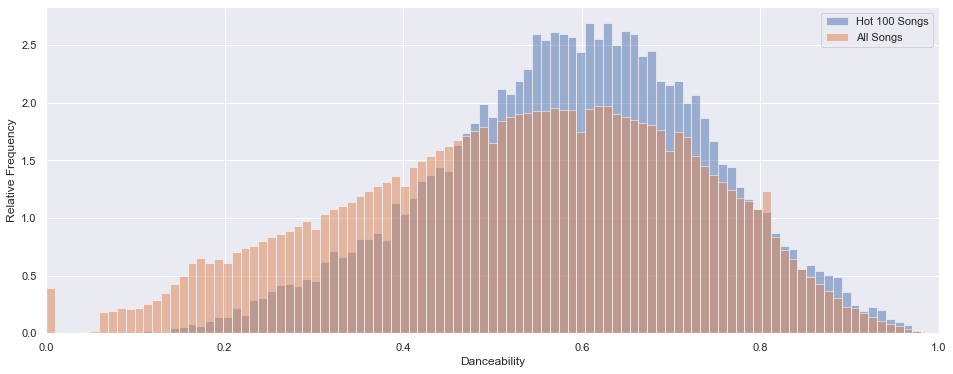

Energy Histogram


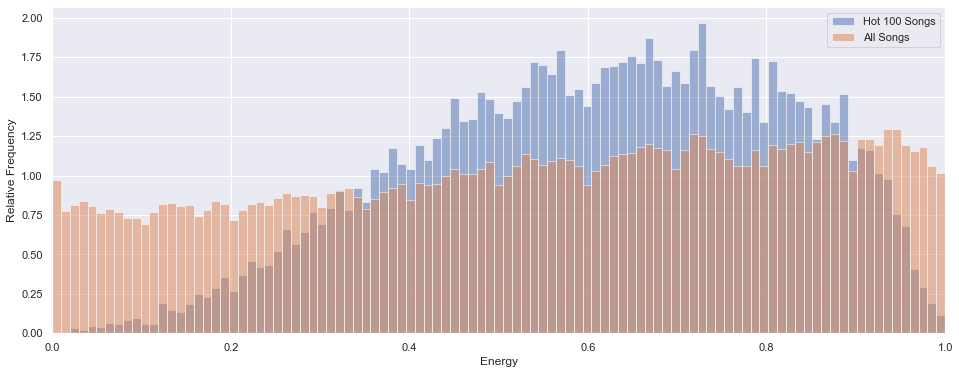

Instrumentalness Histogram


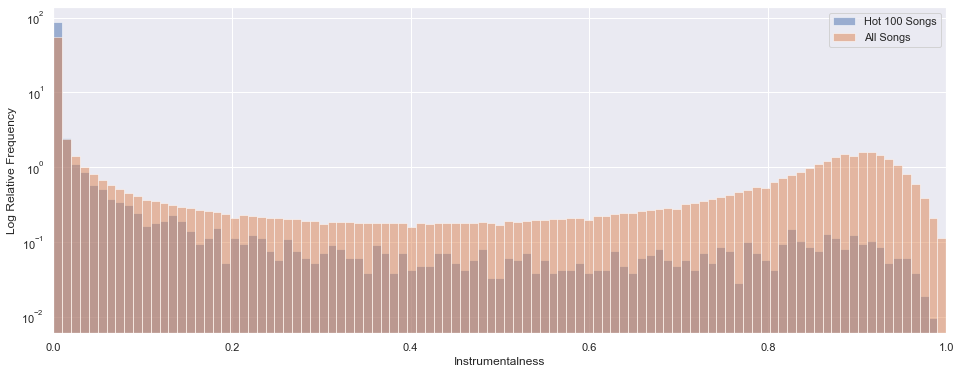

Liveness Histogram


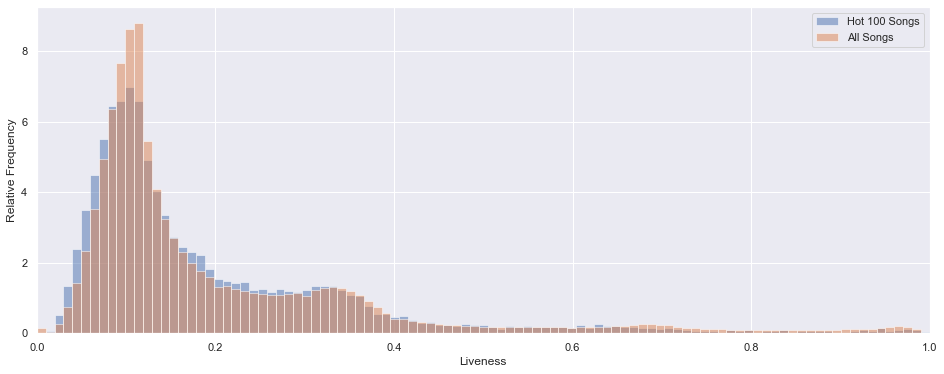

Loudness Histogram


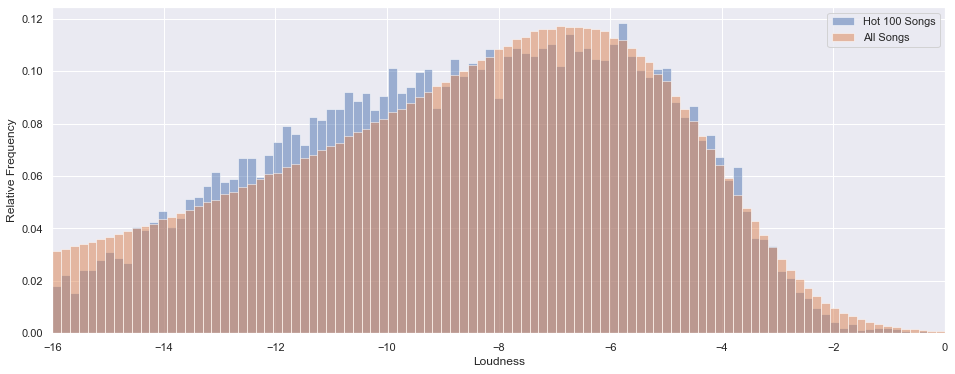

Speechiness Histogram


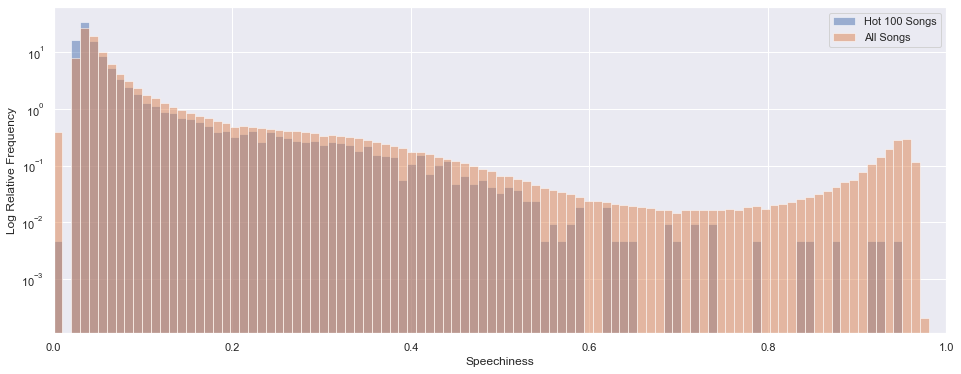

Tempo Histogram


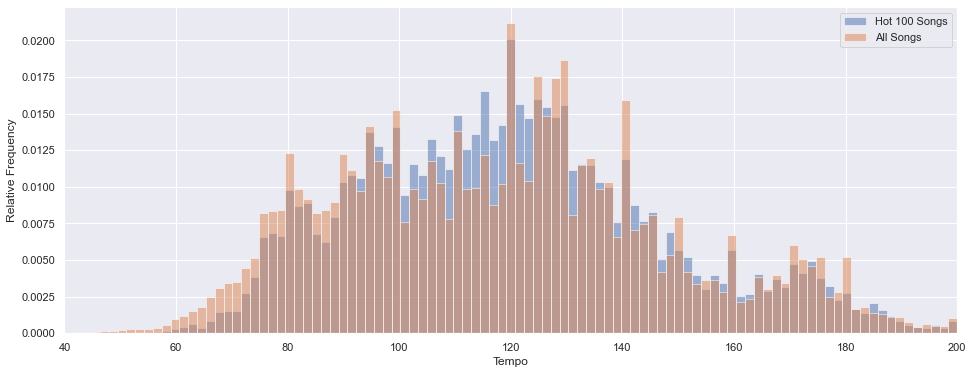

Valence Histogram


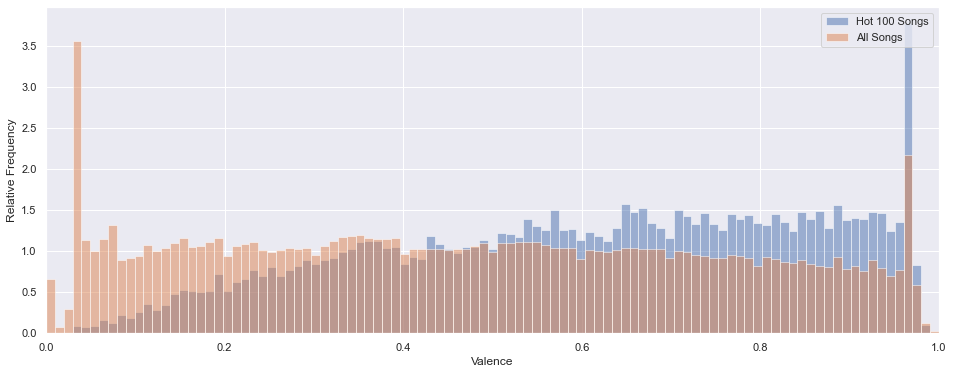

In [18]:
# Histograms of Features
for feature in features:
    compare_histograms(feature, 100, logy=(feature in ['duration_ms', 'instrumentalness', 'speechiness']))

In [19]:
# features requiring specific bin sizes
other_features = ['key', 'mode', 'time_signature']

# Histograms of Features with Specific Bin Sizes
other_bins = {'key': 12, 'mode': 2, 'time_signature': 5}

def compare_histograms_discrete(feature, bins=50, logy=False, figsize=(16, 6)):

    fig, ax = plt.subplots(figsize=figsize)
    
    # use range(bins+1) to offset tick labels and line up with appropriate labels
    plt.hist(df_B100_songs[feature], [x for x in range(bins+1)], alpha=0.5, label='Hot 100 Songs', density=True, align='left')
    plt.hist(df_10M[feature], [x for x in range(bins+1)], alpha=0.5, label='All Songs', density=True, align='left')

    title = f'{feature.title()} Histogram'
#     plt.title(title)
    plt.xlabel(feature.title().replace('_', ' '))
    plt.legend(loc='upper right')
    if logy:
        plt.yscale('log')
        plt.ylabel('Log Relative Frequency')
    else:
        plt.ylabel('Relative Frequency')
    
    ax.set(xticks=[x for x in range(bins)])
    
    # save the image
    plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    # print the title
    print(title)
    
    plt.show()


Key Histogram


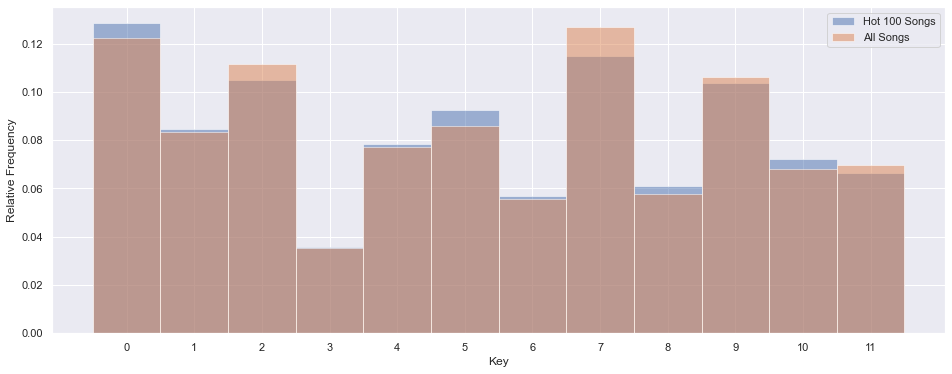

Mode Histogram


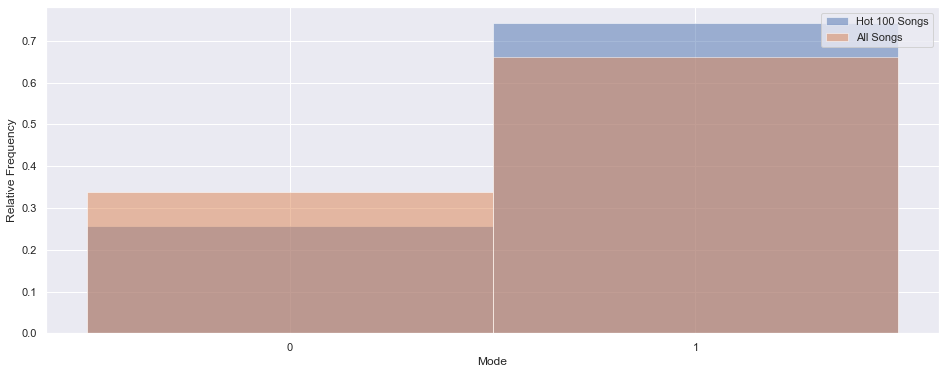

Time_Signature Histogram


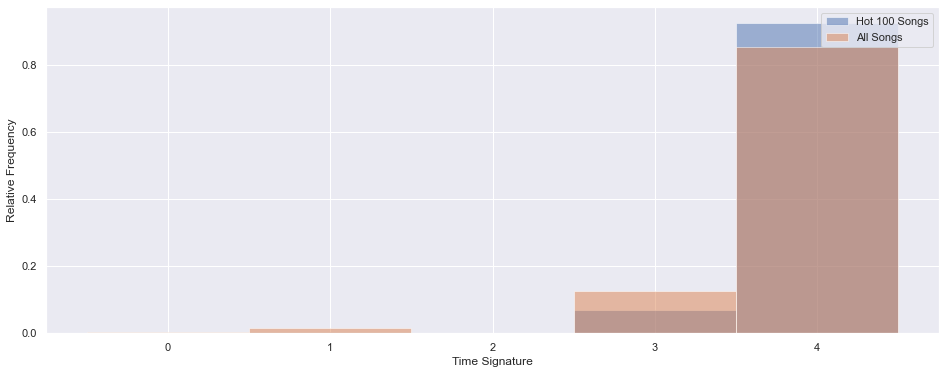

In [20]:
# Histograms of Features with Specific Bin Sizes

# Histograms of Features
for feature in other_features:
    compare_histograms_discrete(feature, other_bins[feature])

Duration Histogram


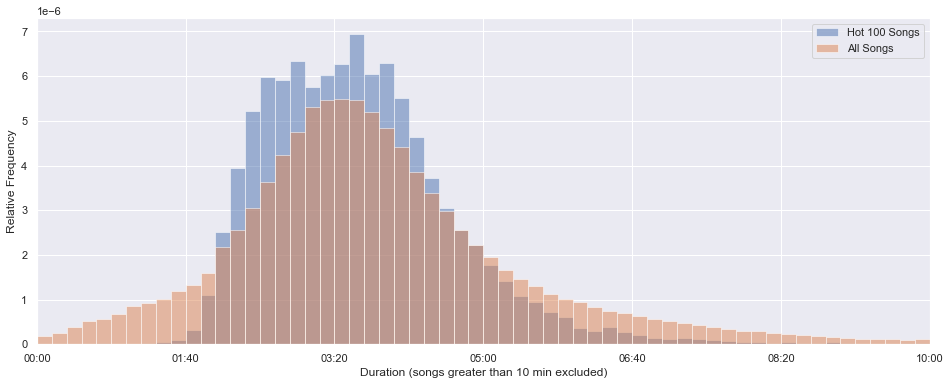

In [21]:
# duration_ms needs to share the x-axis

fig, ax = plt.subplots(figsize=(16, 6))

bins = 1000
maxx = df_10M['duration_ms'].max()
maxx = round(maxx, ndigits=-7)
increment = maxx / bins  # need to do this first or get integer wrap around error
bins = [x for x in range(bins) * increment] 

plt.hist(df_B100_songs['duration_ms'], bins, alpha=0.5, label='Hot 100 Songs', density=True)
plt.hist(df_10M['duration_ms'], bins, alpha=0.5, label='All Songs', density=True)

title = 'Duration Histogram'
# plt.title(title)
plt.xlabel('Duration (songs greater than 10 min excluded)')
plt.legend(loc='upper right')
plt.ylabel('Relative Frequency')
ax.set_xlim((0, 600000))

# https://stackoverflow.com/questions/40395227/minute-and-second-format-for-x-label-of-matplotlib
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
ax.xaxis.set_major_formatter(formatter)

# save the image
plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
# print the title
print(title)

plt.show(feature.title())

# Time Series

In [22]:
# audio features
main_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'
]

# date filter: this affects all time series plotting functions below
# date_filter = 'release_date >= 1958'  # original filter, revised based on later section (see note below)
date_filter = '1958 <= release_date < 2021'

##### NOTE:
* The revised date_filter is based on data quality past 2020
* this is based on analysis later in this notebook: Time Series Counts - Preferred Date Filter
    * this analysis is later in the notebook because it was conducted to explain abberations in time series plots

In [23]:
def plot_attribute_history(feature, dataframe=df_B100_songs, title=None, colour=0):
    """
    Uses songs df_B100_songs by default
    Plots Billboard Hot 100 audio features over time
    """
    # drop values before billboard 100 (lower quality data)
    temp_df = dataframe.query(date_filter)

    plt.figure(figsize=(16, 6))
    ax = sns.lineplot(
        x=temp_df.release_date.dt.year, 
        y=temp_df[feature],
        color=sns.color_palette()[colour], 
        errorbar=('pi', 50)  # middle 50% or IQR
    )
    
    if title:
        title=title
    else:
        title=f'{feature.capitalize()} History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted'
    
    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
    plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.ylabel(feature.capitalize().replace('_', ' '))
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    # print the title
    print(title)
    
    plt.show()


Acousticness History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


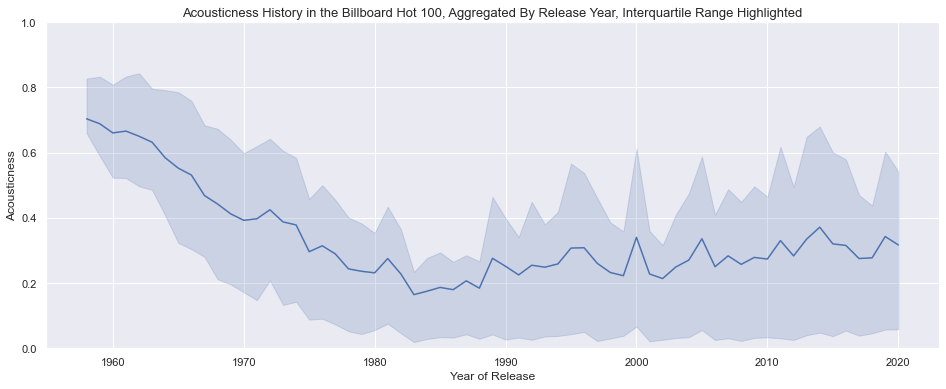

Acousticness History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


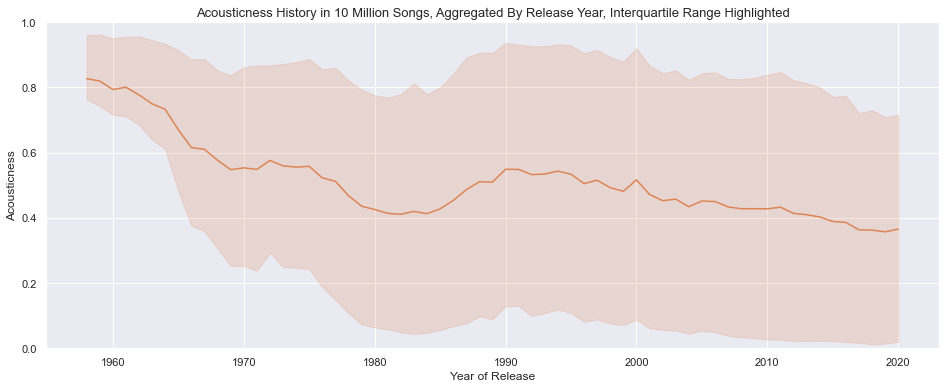

Danceability History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


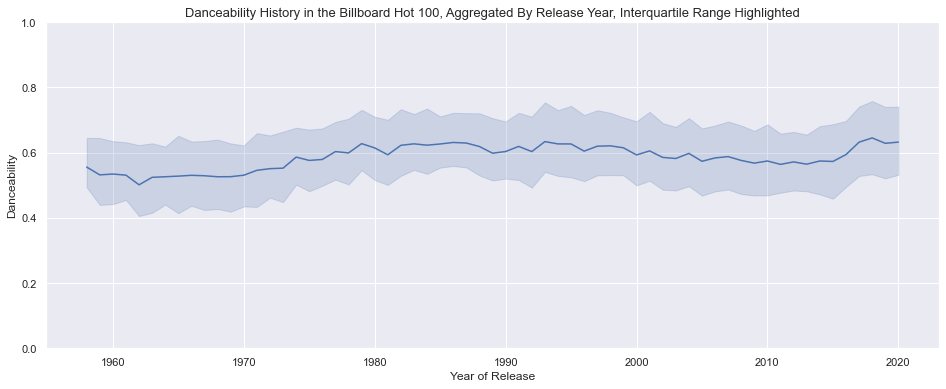

Danceability History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


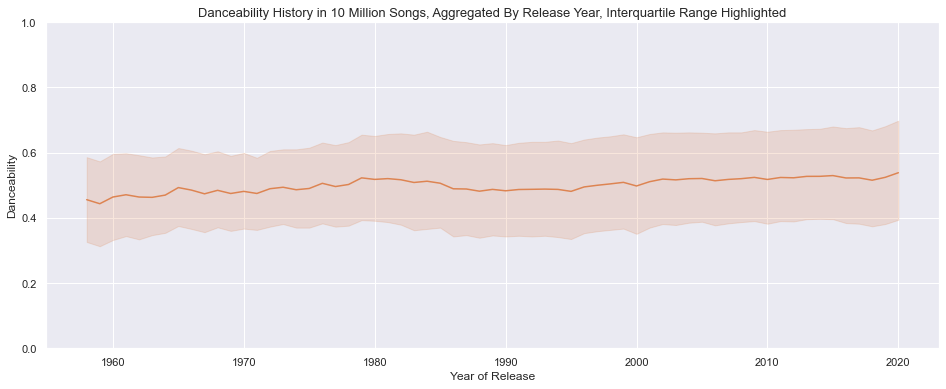

Energy History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


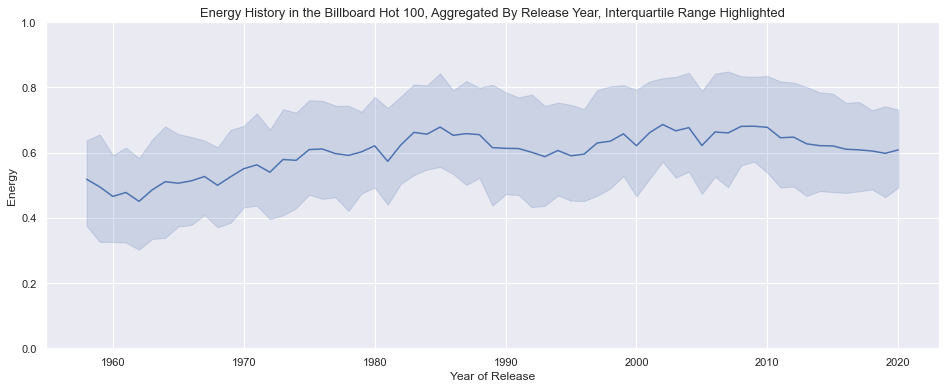

Energy History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


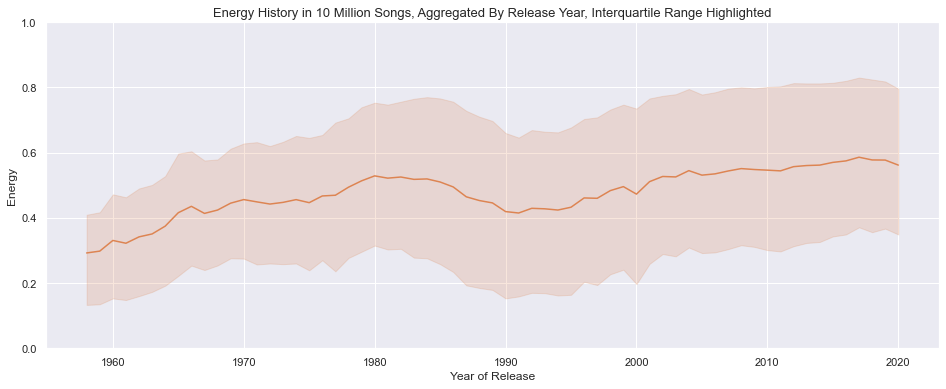

Instrumentalness History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


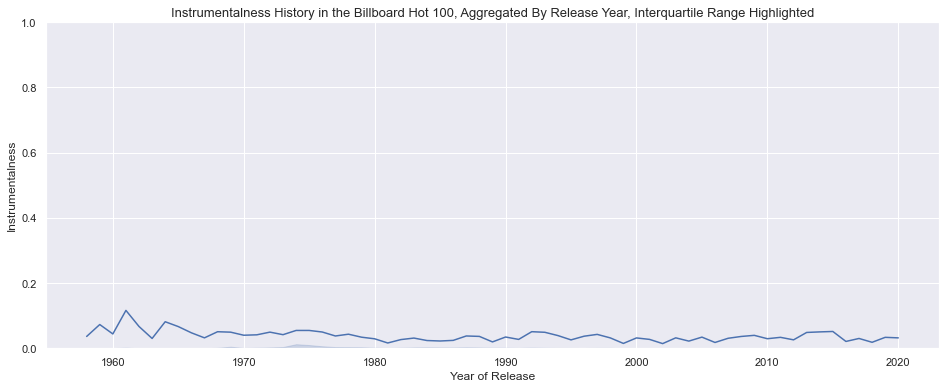

Instrumentalness History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


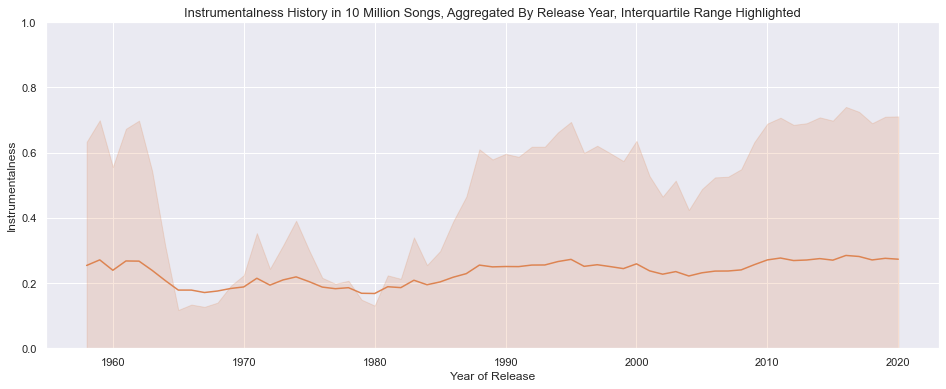

Liveness History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


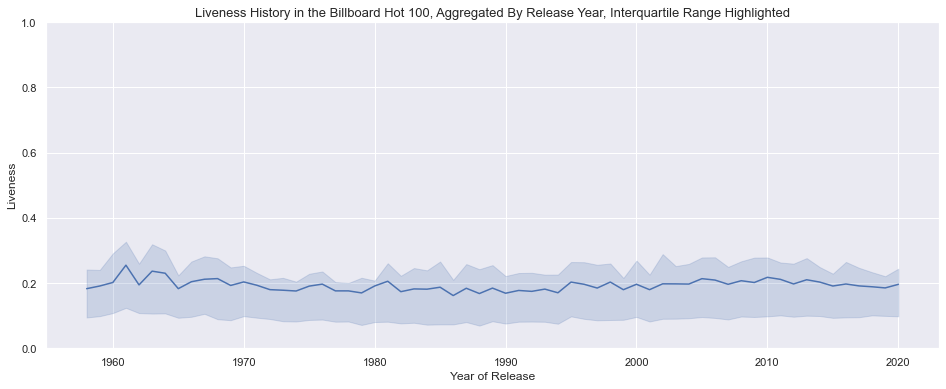

Liveness History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


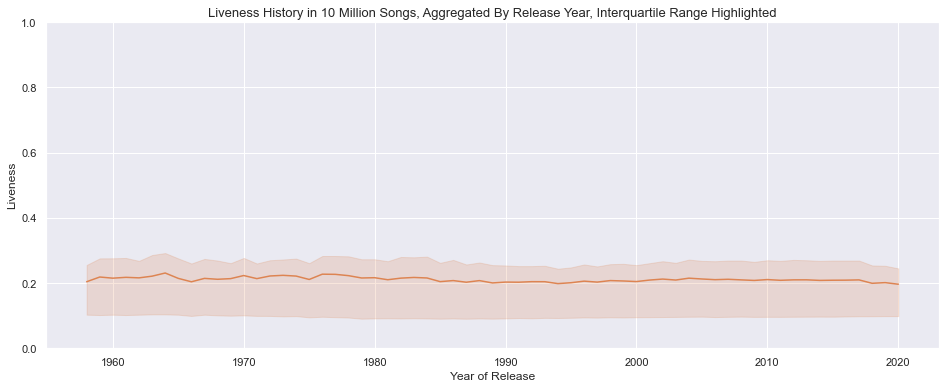

Loudness History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


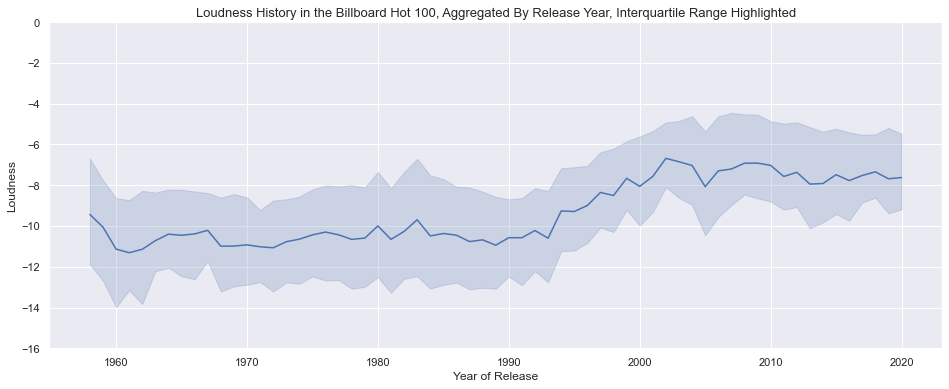

Loudness History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


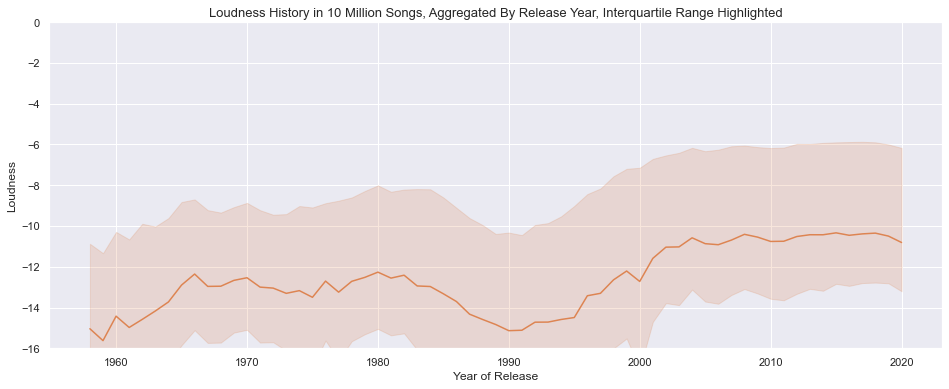

Mode History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


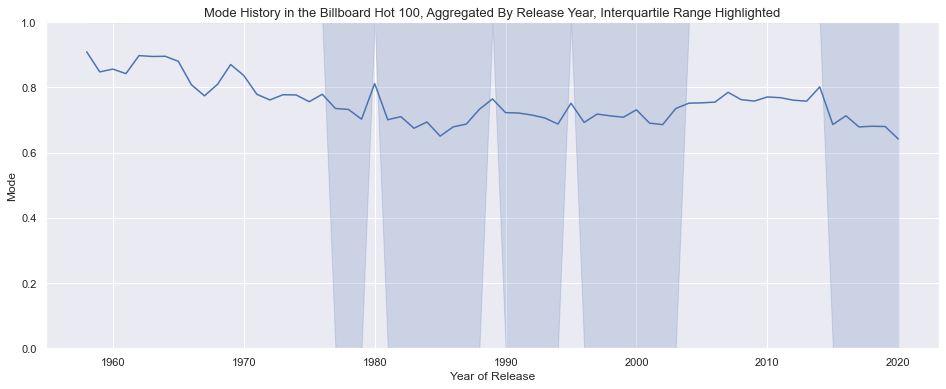

Mode History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


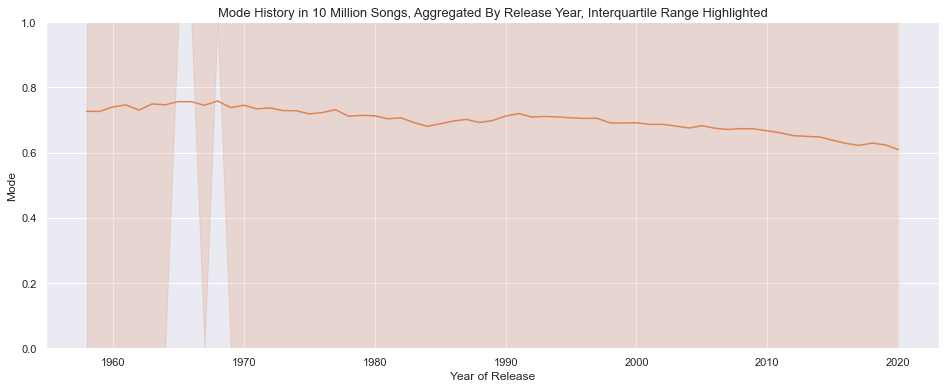

Speechiness History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


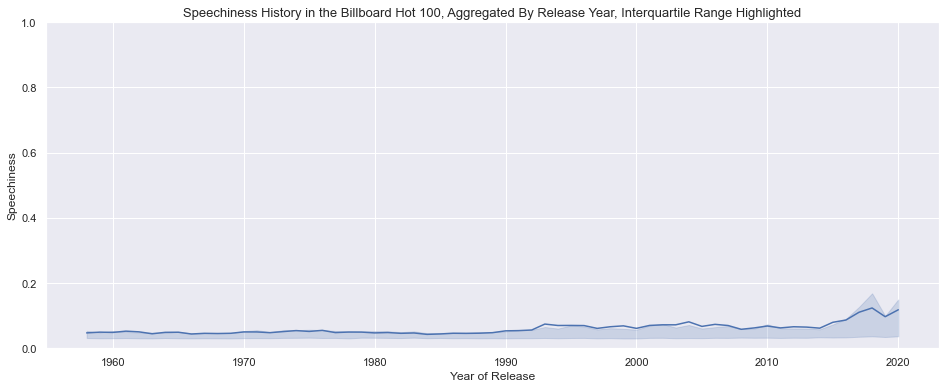

Speechiness History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


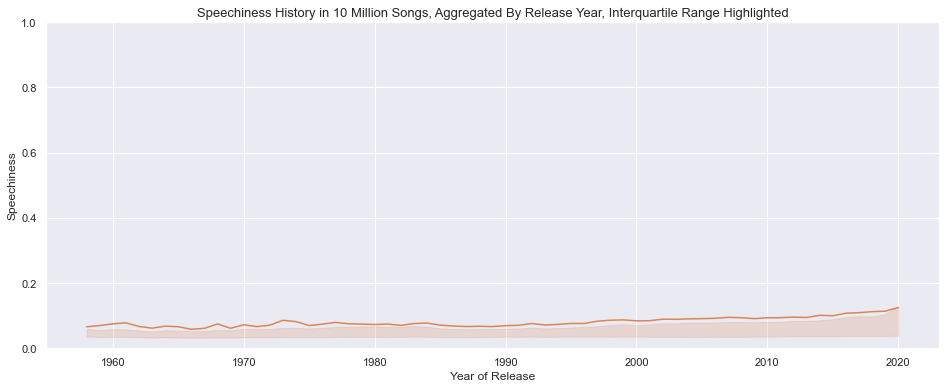

Tempo History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


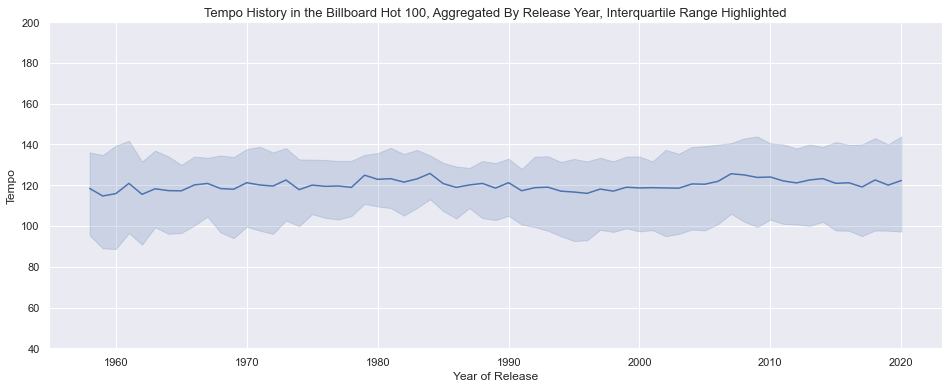

Tempo History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


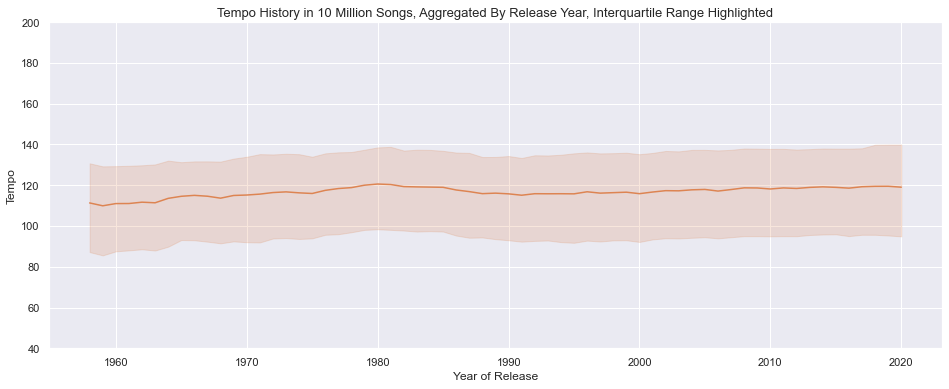

Valence History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


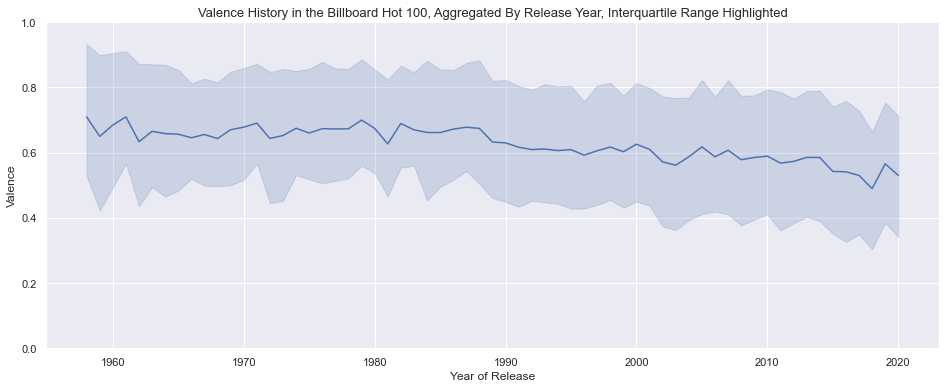

Valence History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


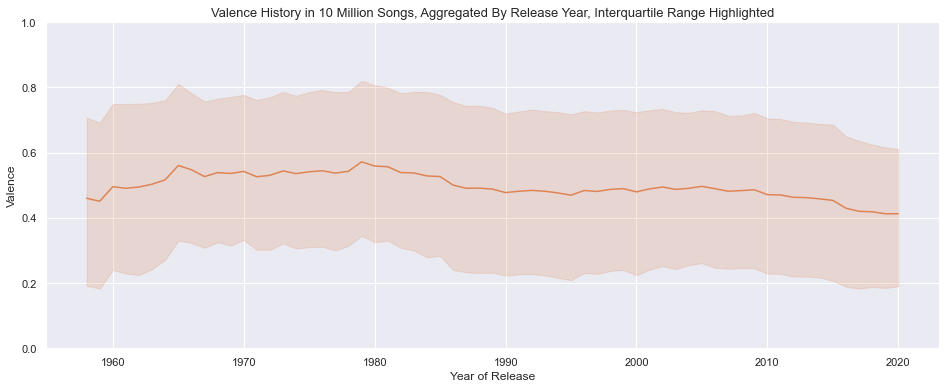

Wall time: 1min


In [24]:
%%time
# plot features for Billboard Hot 100 and All Songs
for feature in main_features:
    # first plot the Billboard Hot 100
    plot_attribute_history(feature)
    # then plot the same feature from the large dataset
    title = f'{feature.capitalize()} History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted'
    plot_attribute_history(feature, dataframe=df_10M, title=title, colour=1)

In [25]:
# audio features
other_features = [
    'key', 'time_signature', # integers don't make sense in timeseries lineplot (maybe heatplot?)
    'duration_ms',  # irregular feature, plotting requires some extra work
]

def plot_duration(feature='duration_ms', dataframe=df_B100_songs, title=None, colour=0):
    """
    Uses songs df_B100_songs 
    Plots Billboard Hot 100 audio features over time
    """
    # drop values before billboard 100 (lower quality data)
    temp_df = dataframe.query(date_filter)
    
    plt.figure(figsize=(16, 6))
    ax = sns.lineplot(
        x=temp_df.release_date.dt.year, 
        y=temp_df[feature],
        color=sns.color_palette()[colour], 
        errorbar=('pi', 50)  # middle 50% or IQR
    )
    
    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    if title:
        title=title
    else:
        title=f'Song Duration History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted'
    
    plt.ylim(120000, 300000)  # reasonable range for duration of music
    
#     plt.title(title, fontsize=13)
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)
    
    plt.show()


Song Duration History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted


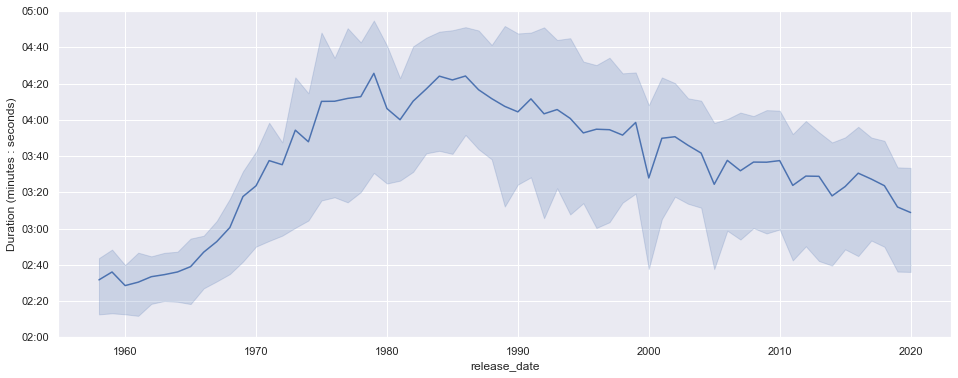

In [26]:
plot_duration(feature='duration_ms')

Song Duration History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted


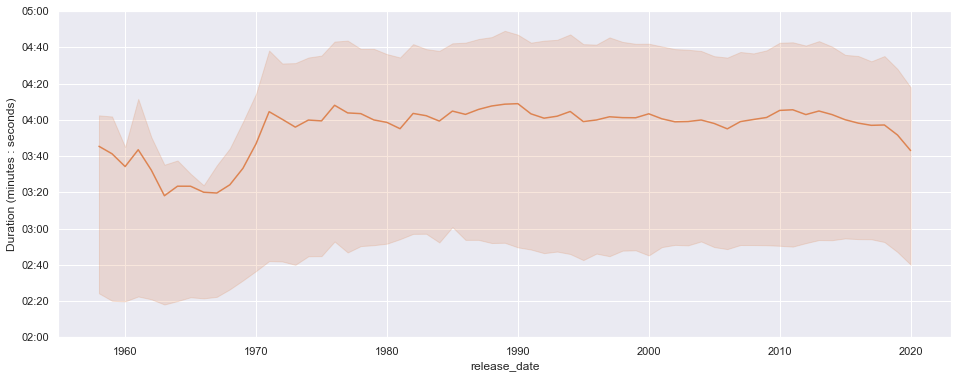

Wall time: 9.14 s


In [27]:
%%time
title = 'Song Duration History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted'
plot_duration(feature='duration_ms', dataframe=df_10M, title=title, colour=1)

### Comparative Time Series

In [28]:
def plot_feature_comparison(feature):
    """
    Uses songs df_B100_songs 
    Plots Billboard Hot 100 audio features over time
    """
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    df1 = df_B100_songs.query(date_filter)
    ax = sns.lineplot(
        x=df1.release_date.dt.year, 
        y=df1[feature],
        color=sns.color_palette()[0], 
        errorbar=None, 
        label='Hot 100 Songs'
    )
    
    df2 = df_10M.query(date_filter)
    ax = sns.lineplot(
        x=df2.release_date.dt.year, 
        y=df2[feature],
        color=sns.color_palette()[1], 
        errorbar=None, 
        label='All Songs'
    )
    
    title=f'{feature.capitalize()} History Comparing the Billboard Hot 100 with All Songs'
            
    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
#     plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.ylabel(feature.capitalize().replace('_', ' '))
    plt.legend(loc='upper right')
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)
    
    plt.show()


def plot_duration_comparison(feature='duration_ms'):
    """
    Uses songs df_B100_songs 
    Plots Billboard Hot 100 audio features over time
    """
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    df1 = df_B100_songs.query(date_filter)
    ax = sns.lineplot(
        x=df1.release_date.dt.year, 
        y=df1[feature],
        color=sns.color_palette()[0], 
        errorbar=None, 
        label='Hot 100 Songs'
    )
    
    df2 = df_10M.query(date_filter)
    ax = sns.lineplot(
        x=df2.release_date.dt.year, 
        y=df2[feature],
        color=sns.color_palette()[1], 
        errorbar=None, 
        label='All Songs'
    )
    
    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    title='Song Duration History Comparing the Billboard Hot 100 with All Songs'
    
    plt.ylim(120000, 300000)  # reasonable range for duration of music
    
#     plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.legend(loc='upper right')
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)
    
    plt.show()


Acousticness History Comparing the Billboard Hot 100 with All Songs


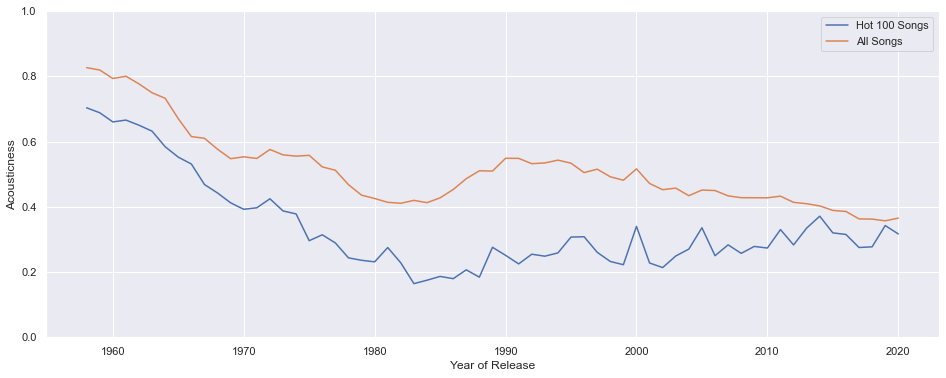

Danceability History Comparing the Billboard Hot 100 with All Songs


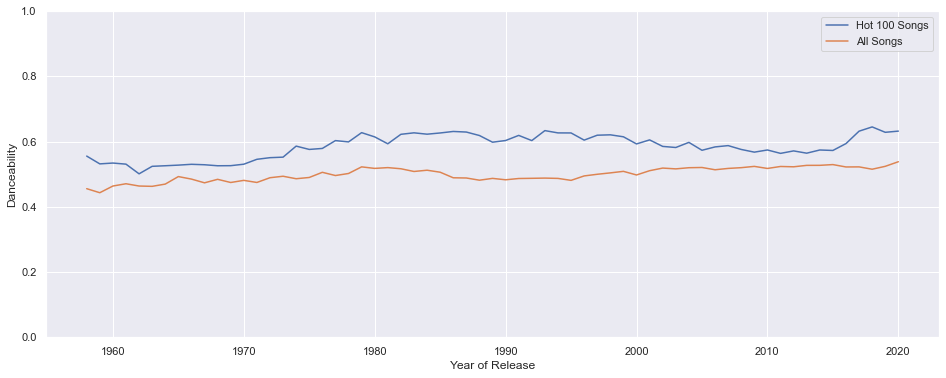

Energy History Comparing the Billboard Hot 100 with All Songs


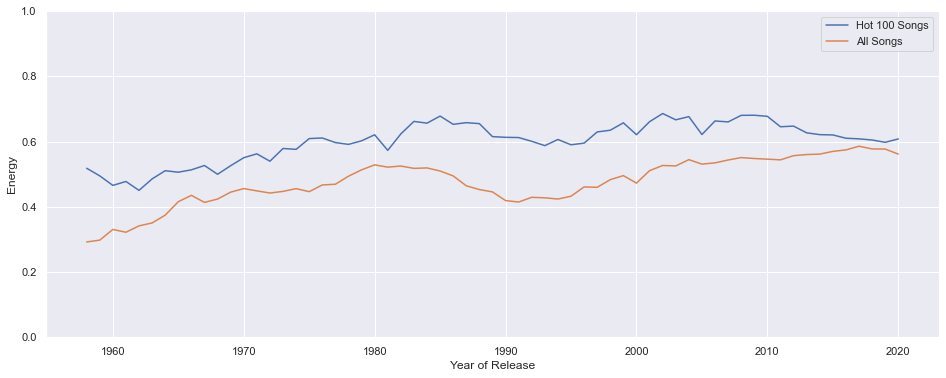

Instrumentalness History Comparing the Billboard Hot 100 with All Songs


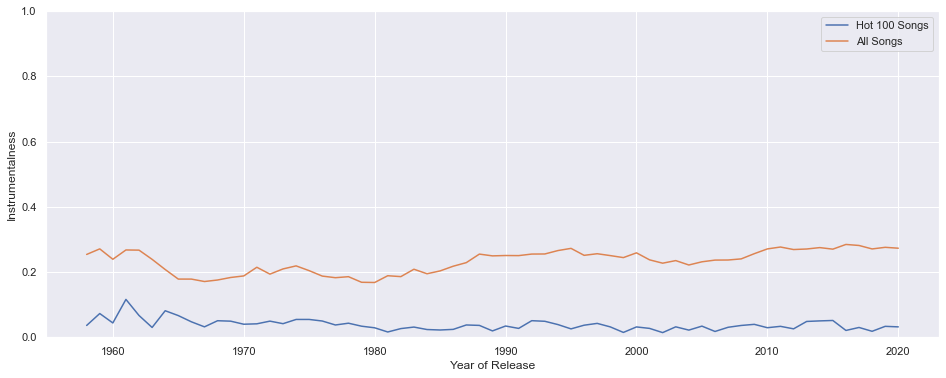

Liveness History Comparing the Billboard Hot 100 with All Songs


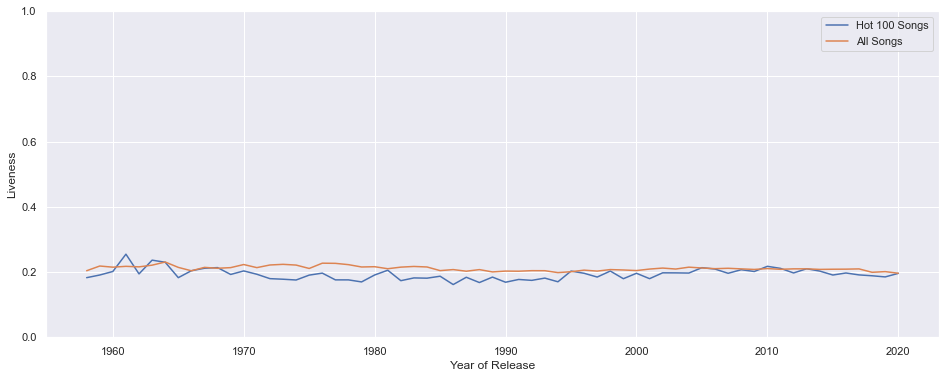

Loudness History Comparing the Billboard Hot 100 with All Songs


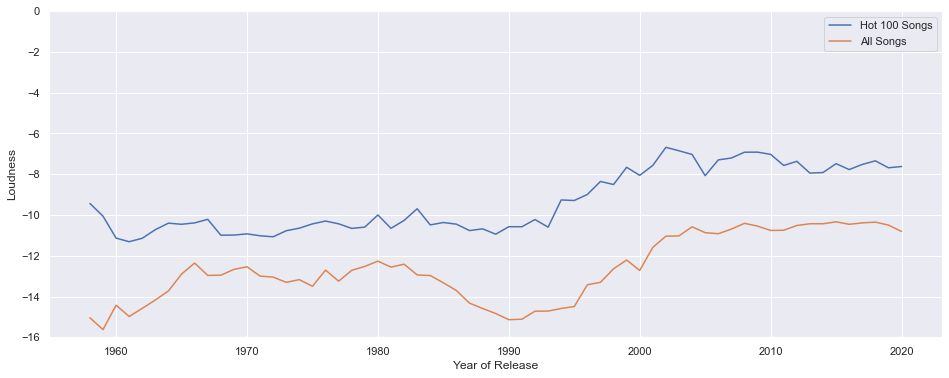

Mode History Comparing the Billboard Hot 100 with All Songs


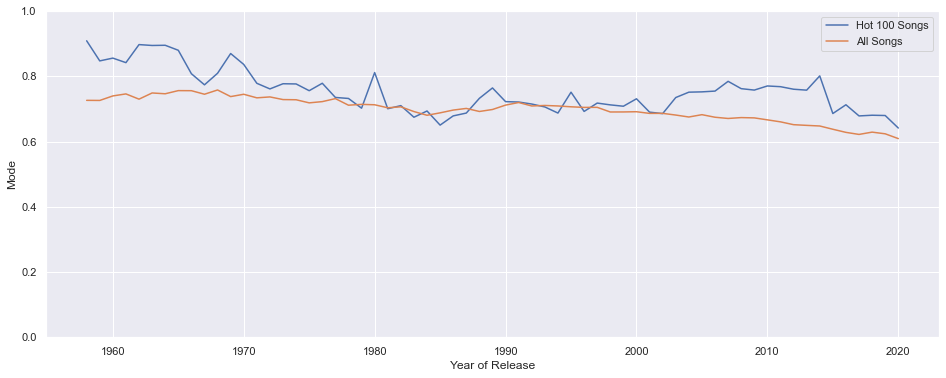

Speechiness History Comparing the Billboard Hot 100 with All Songs


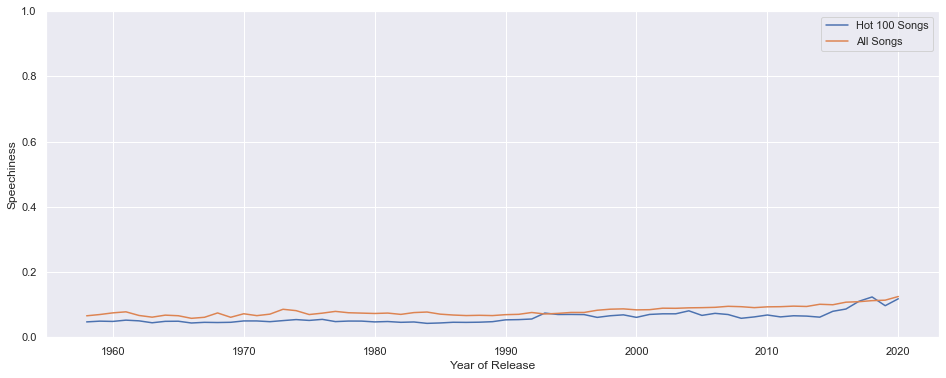

Tempo History Comparing the Billboard Hot 100 with All Songs


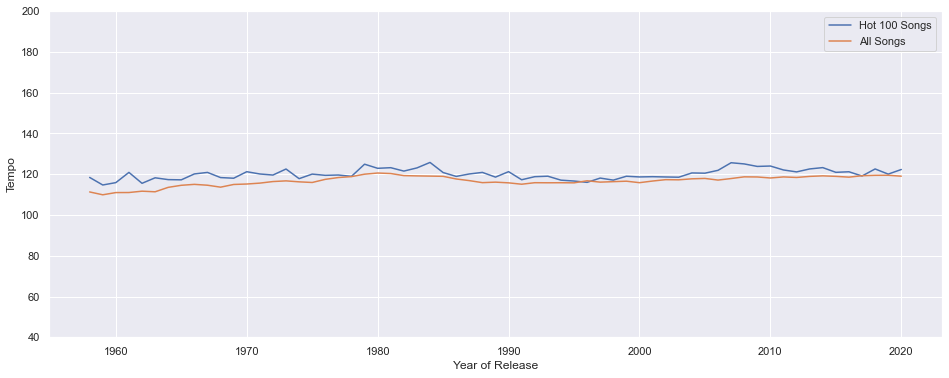

Valence History Comparing the Billboard Hot 100 with All Songs


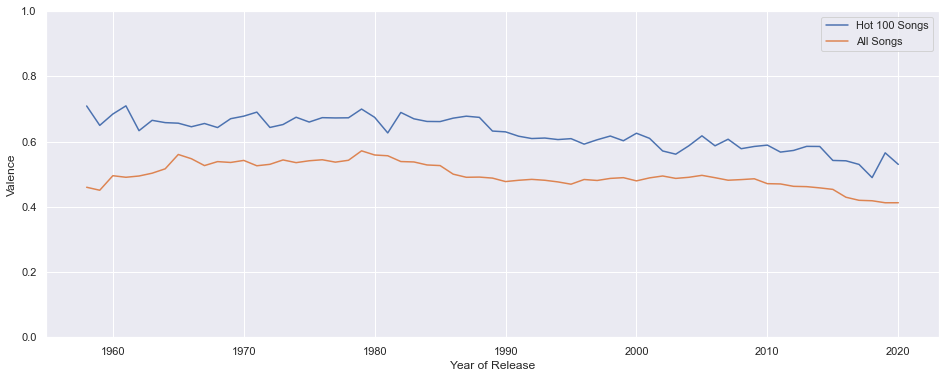

Song Duration History Comparing the Billboard Hot 100 with All Songs


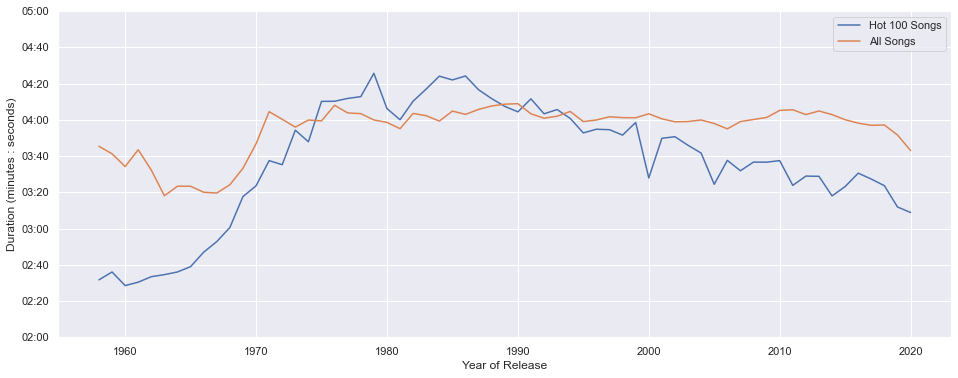

Wall time: 1min 2s


In [29]:
%%time
# audio features
main_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'
]

for feature in main_features:
    plot_feature_comparison(feature)
plot_duration_comparison()

### Time Series Counts - Preferred Date Filter
* data seems to deteriorate after 2020, with large movements in music trends (CORRECT)
* alternatively, this could be due to significant societal changes and preferences (NOT VERIFIABLE)
##### Let's find out!

In [30]:
df_10M.release_date.dt.year.value_counts().reset_index().sort_values('index', ascending=False).head()

,index,release_date
98,2022.000,234
26,2021.000,71985
8,2020.000,307877
10,2019.000,280639
11,2018.000,273200


In [31]:
df_B100_songs.release_date.dt.year.value_counts().reset_index().sort_values('index', ascending=False).head()

,index,release_date
57,2022,202
6,2021,524
0,2020,653
5,2019,525
2,2018,564


In [32]:
# find max dates for each dataset

# SQL
max_date_sql = 1644537600000
pd.to_datetime(max_date_sql, unit='ms', origin='unix')

Timestamp('2022-02-11 00:00:00')

In [33]:
# Billboard Hot 100
df_B100.sort_values('date', ascending=False).head(1)['date']

0   2021-11-06
Name: date, dtype: datetime64[ns]

In [34]:
# CSV
pd.read_csv('D:/RYERSON/820/Datasets/Spotify 1.2M+ Songs/tracks_features.csv').sort_values('release_date', ascending=False).head(1)['release_date']

1134062    2020-12-18
Name: release_date, dtype: object

In [35]:
# Latest Release Dates by Dataset
latest_sql = pd.to_datetime('2022-02-11 00:00:00')
latest_B100 = pd.to_datetime('2021-11-06 00:00:00')
latest_csv = pd.to_datetime('2020-12-18 00:00:00')

# max date option 1 (all datasets consistent):
maxdate_1 = min(latest_sql, latest_B100, latest_csv)

# max date option 2 (all Billboard 100 songs):
maxdate_2 = min(latest_sql, latest_B100)

# options for filtering
maxdate_1, maxdate_2

(Timestamp('2020-12-18 00:00:00'), Timestamp('2021-11-06 00:00:00'))

In [36]:
# let's check the quantiy (not quality) of 2021 (with SQL, without CSV) vs 2020 (both)

df_10M.query('2021 <= release_date < 2022').shape[0], df_10M.query('2020 <= release_date < 2021').shape[0]

(71985, 307877)

In [37]:
# only 23% of the songs during 2021 vs 2020: looks like maxdate_1 is a better choice
df_10M.query('2021 <= release_date < 2022').shape[0] / df_10M.query('2020 <= release_date < 2021').shape[0]

0.23381090500427118

##### CONCLUSION: We should only include data up to, but not including 2021

In [38]:
if []:
    print('hi')

### Billboard Charts Historical Plots

In [39]:
# audio features
normalised_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'mode', 'speechiness', 'valence'
]

# features to normalise
features_to_normalise = [
    'loudness', 'tempo', 'duration_ms', 'time_signature'
]

def plot_billboard_history(normalised_features, features_to_normalise):
    """
    Uses songs df_B100
    Plots Billboard Hot 100 audio features over time
    """
    if features_to_normalise:  # if there are features to normalise
        # combine lists of features
        list_of_features = sorted([*normalised_features, *features_to_normalise])

        # create the normalised dataframe
        df = df_B100.dropna().copy()
        n = features_to_normalise  # just to shorten the next line of code
        df[[*n]] = (df[[*n]]-df[[*n]].min()) / (df[[*n]].max()-df[[*n]].min())
    else:
        list_of_features = normalised_features
        df = df_B100.dropna().copy()
    
    # create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for feature in list_of_features:
        ax = sns.lineplot(
            x=df.date.dt.year, 
            y=df[feature],
            errorbar=None,  
            linewidth=1.5,
            label=feature.replace('_', ' ').title()
        )
        
    title='Billboard Hot 100 Historical Charts - All Features Normalised'
        
#     plt.title(title, fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('Audio Feature (Normalised)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


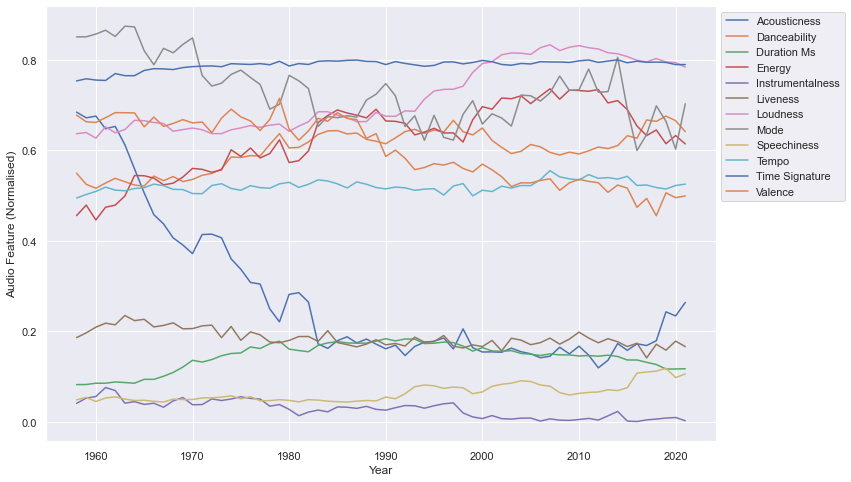

In [40]:
# plot all features historically
plot_billboard_history(normalised_features, features_to_normalise)

In [41]:
# plot individual features

def plot_billboard_history_by_feature(feature):
    """
    Uses songs df_B100
    Plots Billboard Hot 100 audio features over time
    """
    df = df_B100.dropna().copy()
    figsize=(16, 8)

    plt.figure(figsize=figsize)

    ax = sns.lineplot(
        x=df.date.dt.year, 
        y=df[feature],
        errorbar=('pi', 50),  # IQR
        linewidth=2,
        color=sns.color_palette()[2]  # different colour to differentiate with other plots
    )

    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    elif feature == 'time_signature':
        plt.ylim(0, 5) 
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
        
    title = 'Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - {}'.format(feature.replace('_', ' ').title())

#     plt.title(title, fontsize=13)
    plt.xlabel('Year')
    plt.ylabel(feature.capitalize().replace('_', ' '))

    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)

    plt.show()

    
    
def plot_billboard_history_duration(feature='duration_ms'):
    
    df = df_B100.dropna().copy()
    figsize=(16, 8)
    plt.figure(figsize=figsize)

    ax = sns.lineplot(
        x=df.date.dt.year, 
        y=df[feature],
        errorbar=('pi', 50),  # IQR
        linewidth=2,
        color=sns.color_palette()[2]  # different colour to differentiate with other plots
    )

    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    plt.ylim(120000, 300000)  # reasonable range for duration of music
        
    title = 'Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Song Duration'

#     plt.title(title, fontsize=13)
    plt.xlabel('Year')

    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)

    plt.show()



Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Acousticness


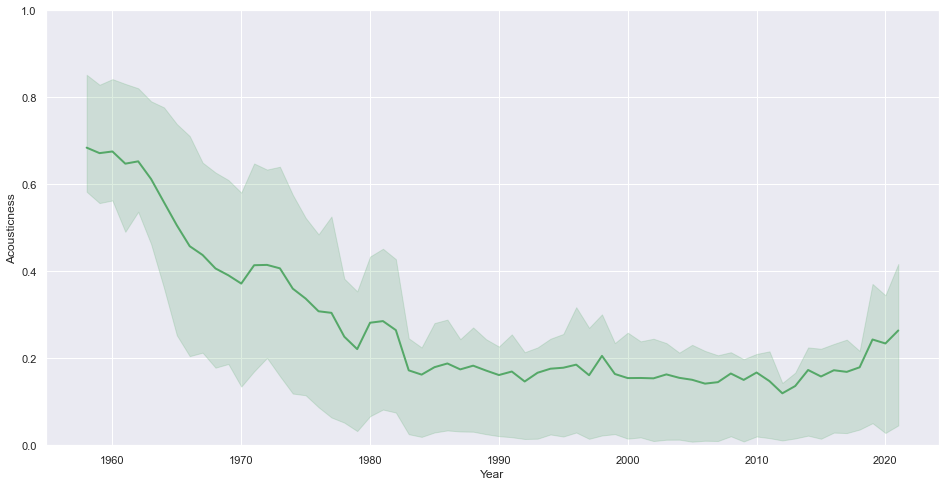

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Danceability


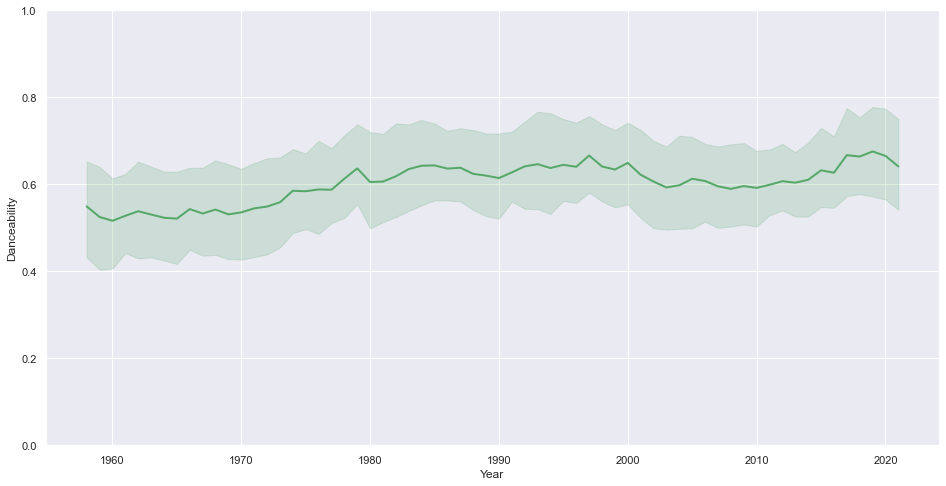

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Energy


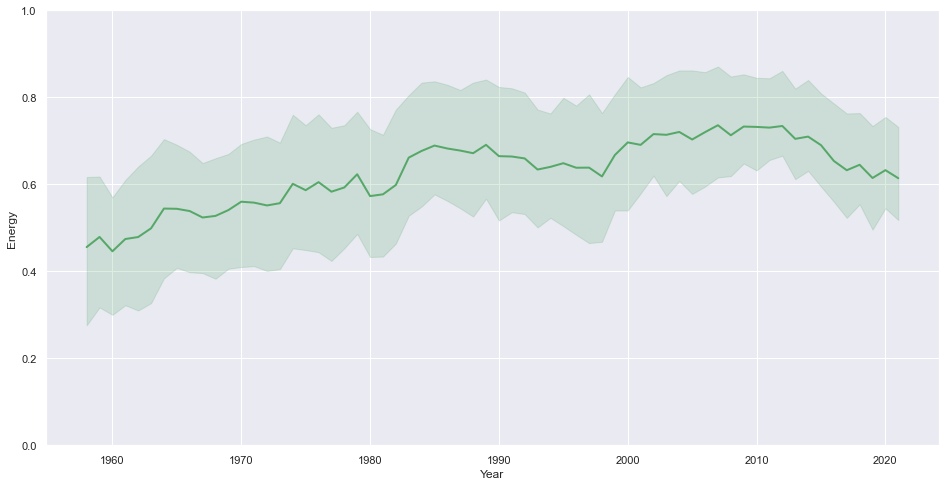

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Instrumentalness


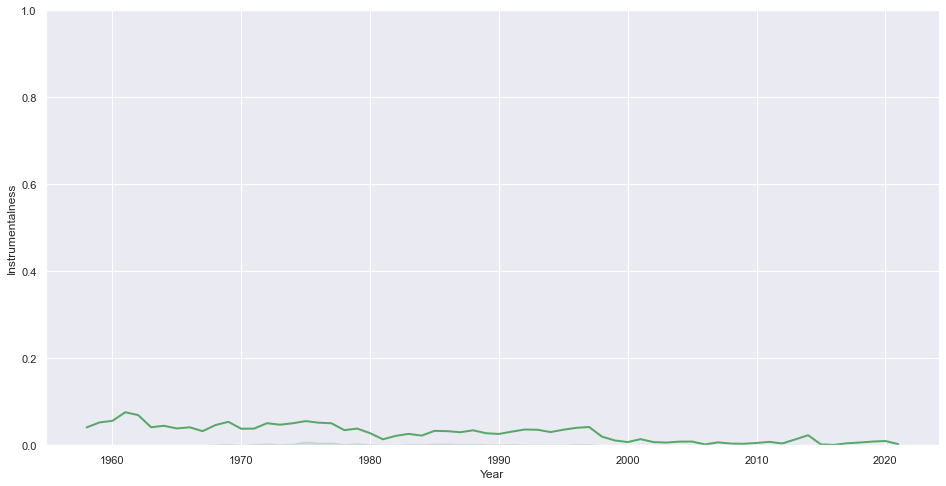

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Liveness


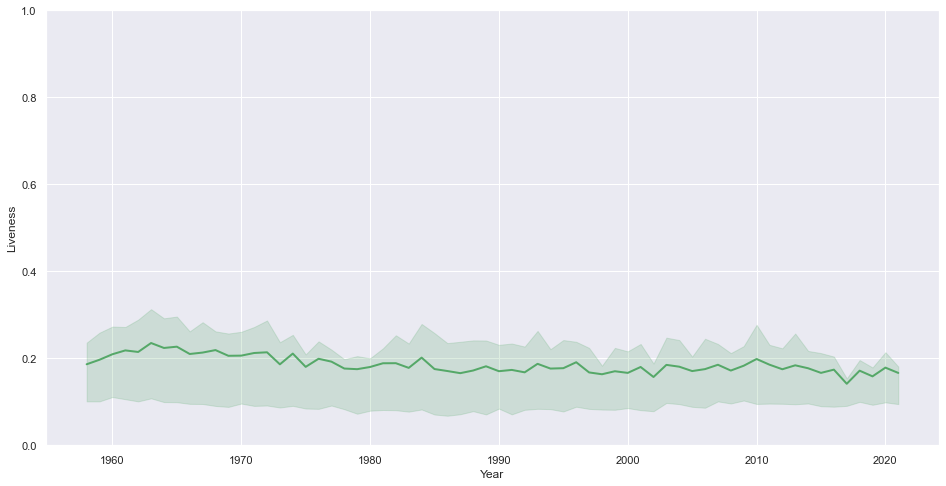

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Loudness


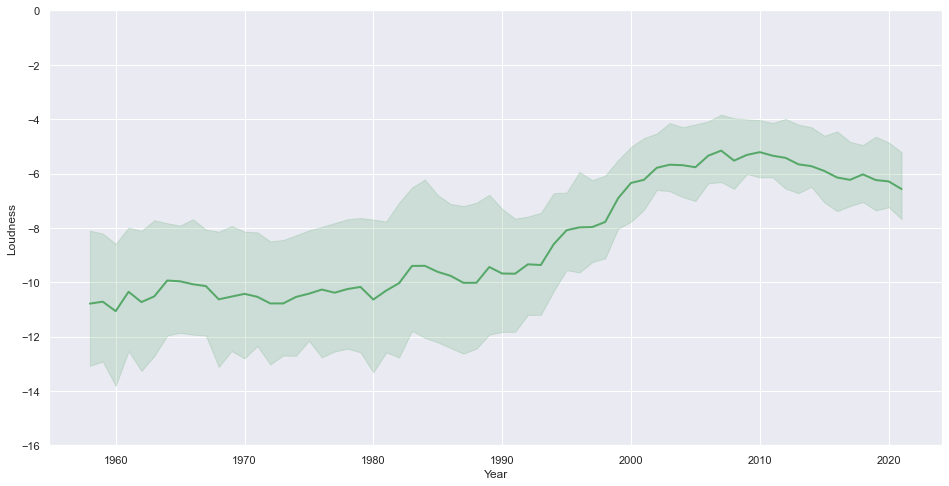

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Mode


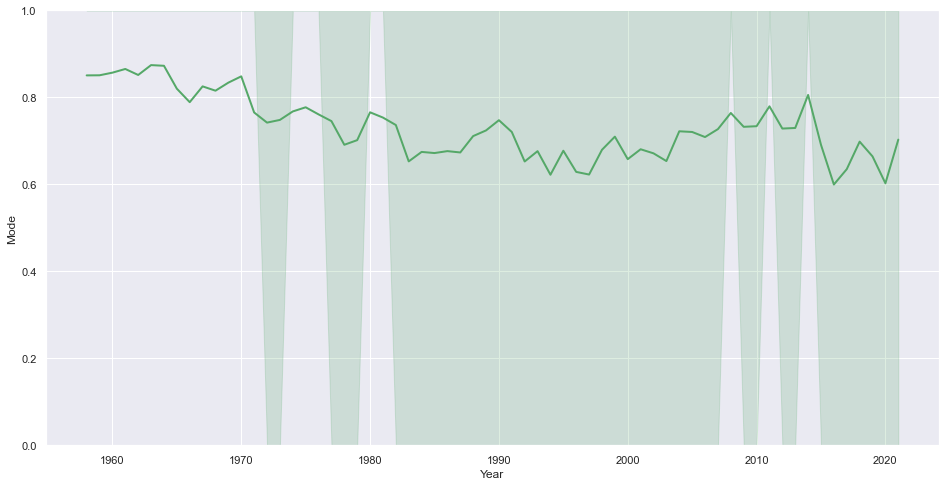

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Speechiness


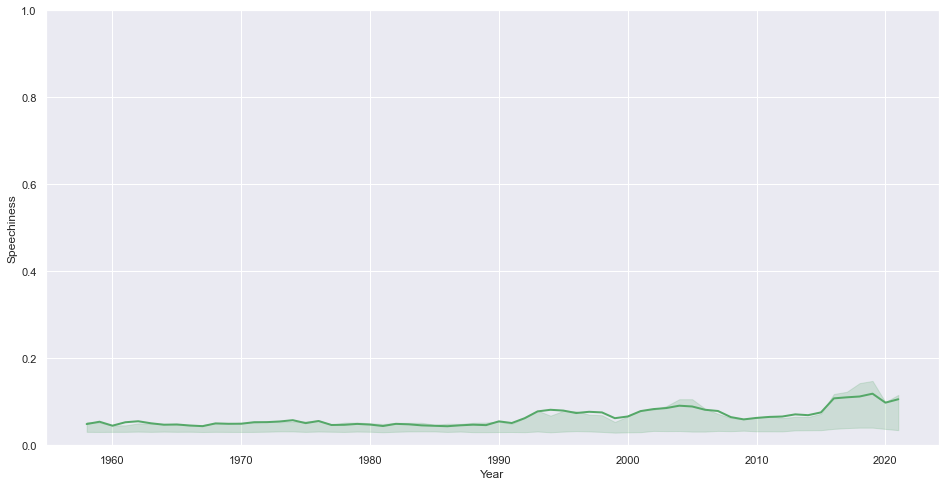

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Tempo


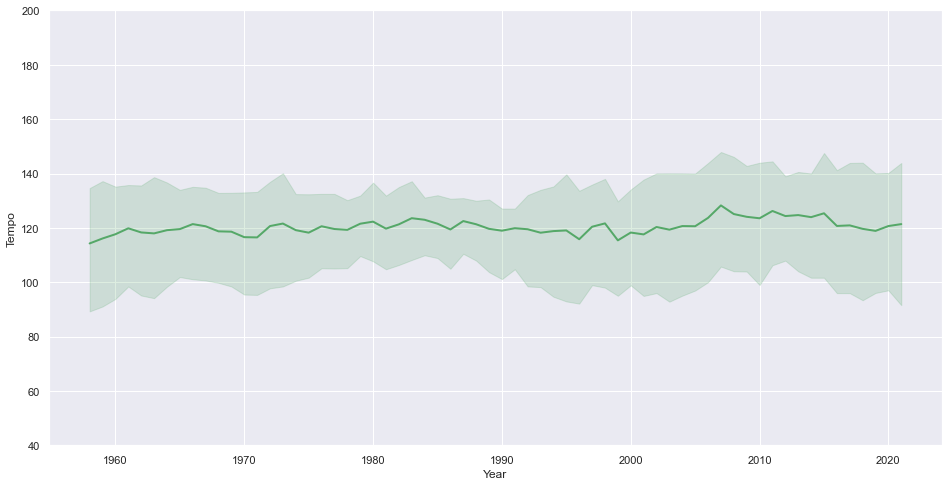

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Time Signature


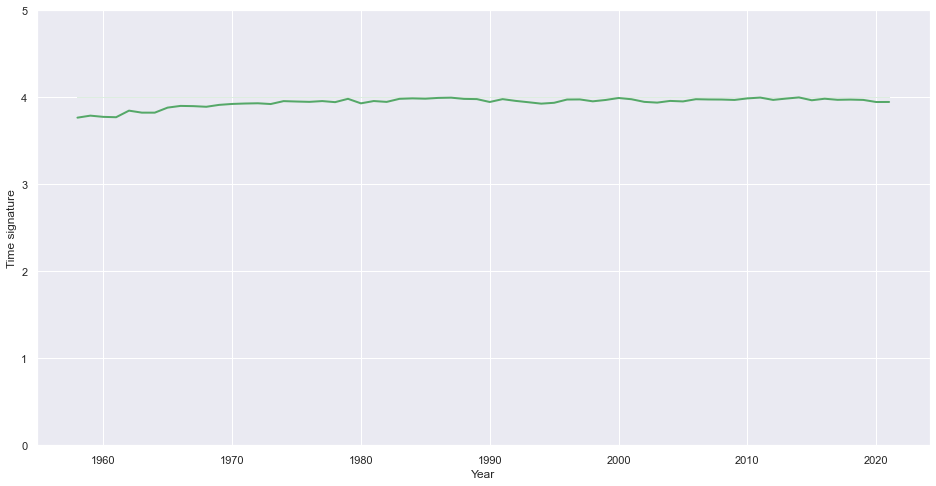

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Valence


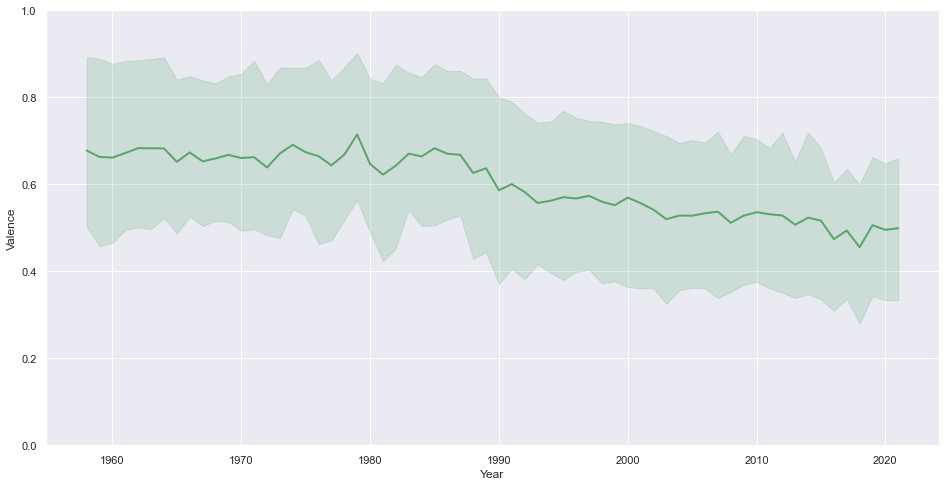

Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Song Duration


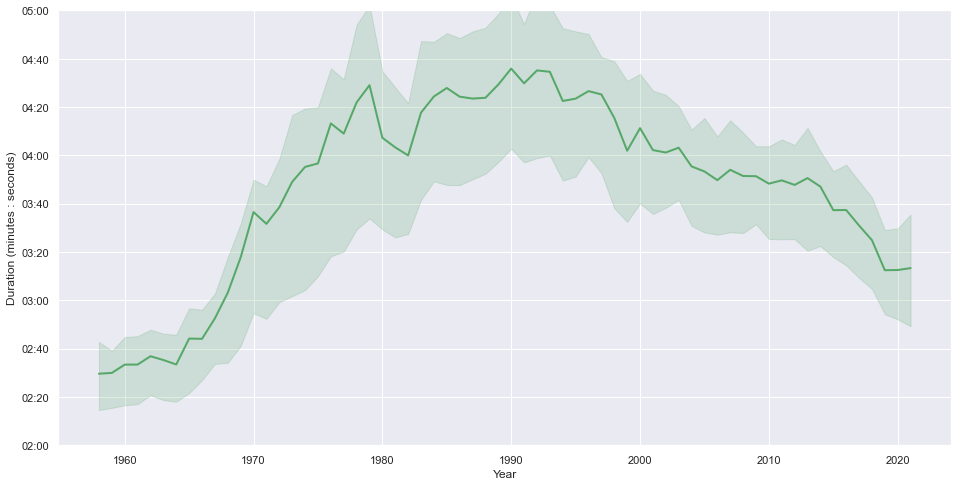

In [42]:
# make the plots
list_of_features = ['acousticness',  'danceability', 'energy', 'instrumentalness', 
                    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

for feature in list_of_features:
    plot_billboard_history_by_feature(feature)
    
plot_billboard_history_duration()

# Correlation Analysis

Correlation of Audio Features - Billboard Hot 100 Songs


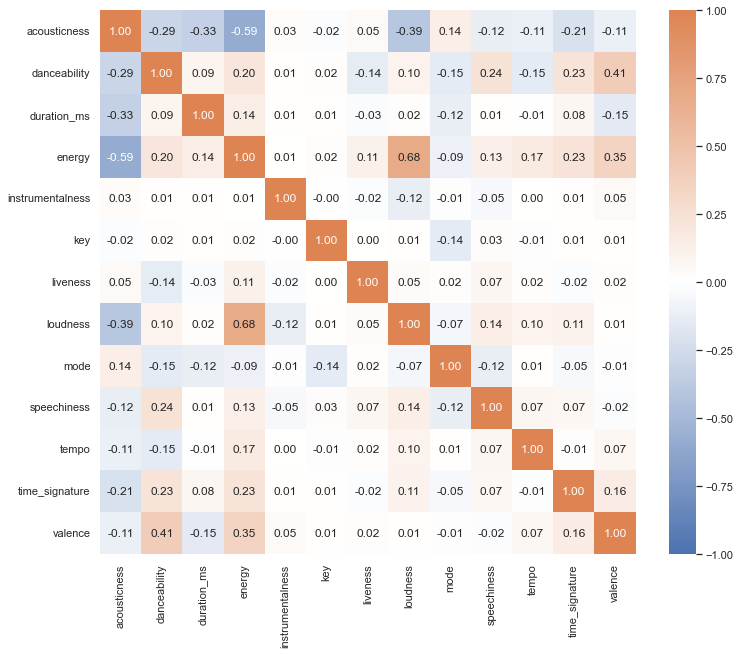

In [43]:
# correlation matrix - Billboard Hot 100
corr_B100 = df_B100_songs.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_B100, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Audio Features - Billboard Hot 100 Songs'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Audio Features - All Songs


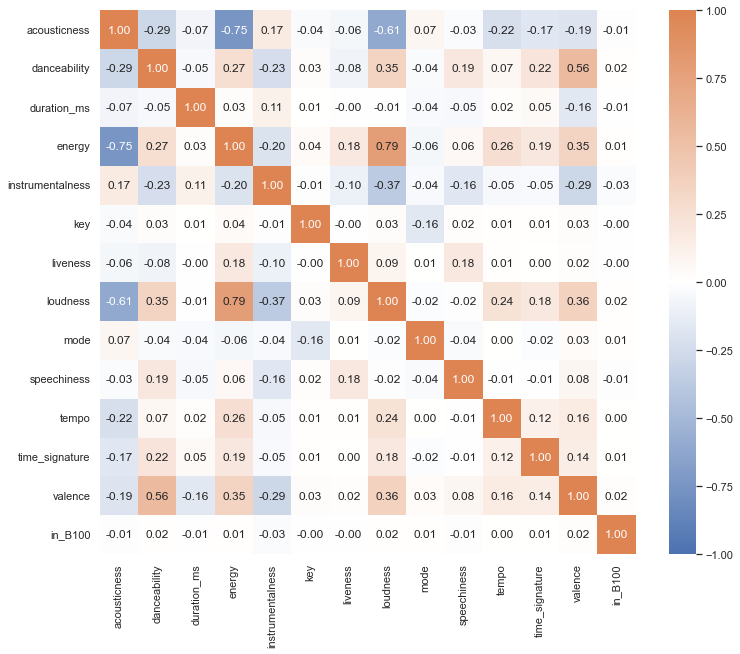

In [44]:
# correlation matrix - All Songs
corr_10M = df_10M.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_10M, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Audio Features - All Songs'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Difference in Correlation of Audio Features - Billboard Hot 100 Minus All Songs


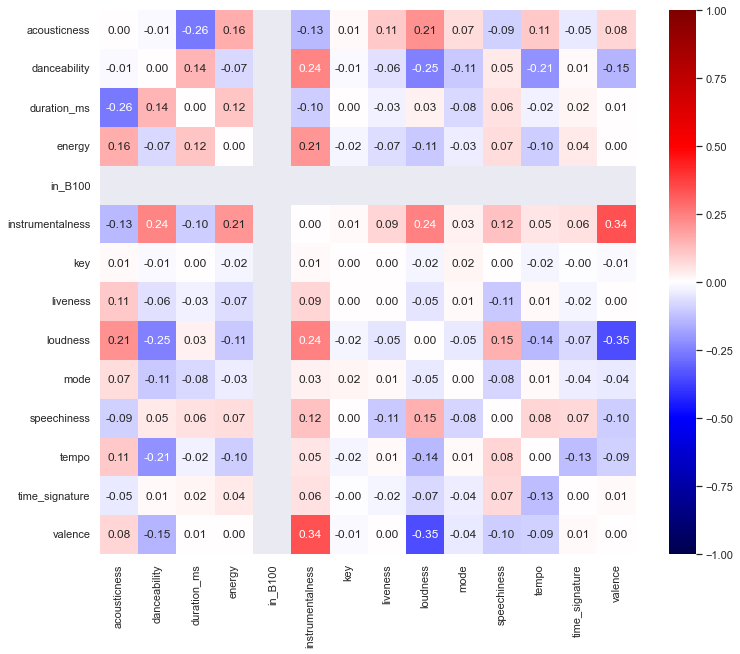

In [45]:
# differences between Billboard Hot 100 and All Songs
corr_diff = corr_B100 - corr_10M

# plot
palette = 'seismic'  # to differentiate from standard colour palette
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_diff, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Difference in Correlation of Audio Features - Billboard Hot 100 Minus All Songs'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

In [46]:
# Billboard 100 List - correlation with max weeks on board
df_B100_SORTED = df_B100.sort_values('weeks-on-board', ascending=False).drop_duplicates(subset=['song', 'artist']).drop(['date', 'id', 'rank', 'last-week'], axis=1).reset_index(drop=True)

Correlation of Billboard Rankings to Audio Features


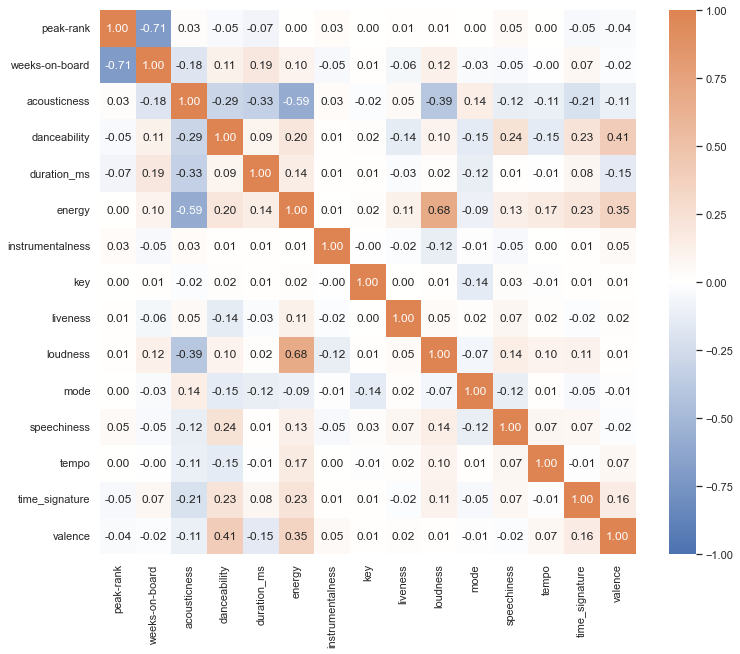

In [47]:
# correlation matrix - All Songs
corr_billboard_weeks = df_B100_SORTED.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_billboard_weeks, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Billboard Rankings to Audio Features'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Weeks on Billboard Hot 100 vs Audio Features


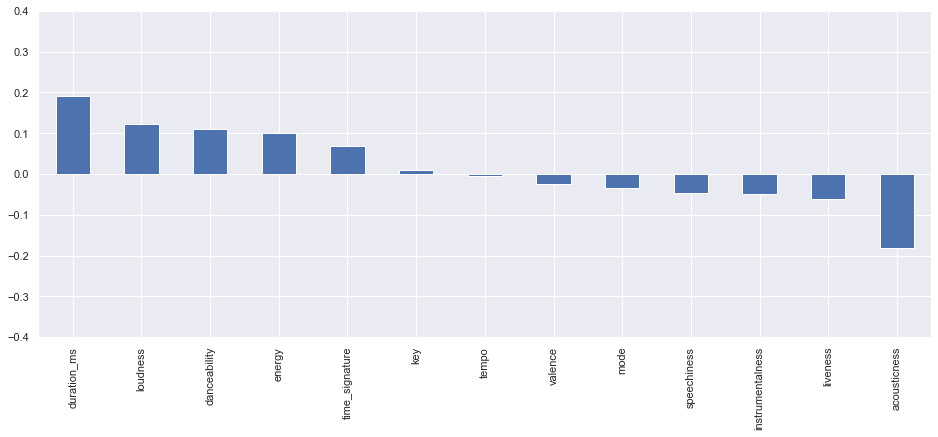

In [48]:
# correlated with weeks on board in Billboard Hot 100
corr_billboard_weeks['weeks-on-board'].sort_values(ascending=False)[1:-1].plot(kind='bar', figsize=(16,6))
title='Correlation of Weeks on Billboard Hot 100 vs Audio Features'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(-0.4, 0.4)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Peak Rank on Billboard Hot 100 vs Audio Features


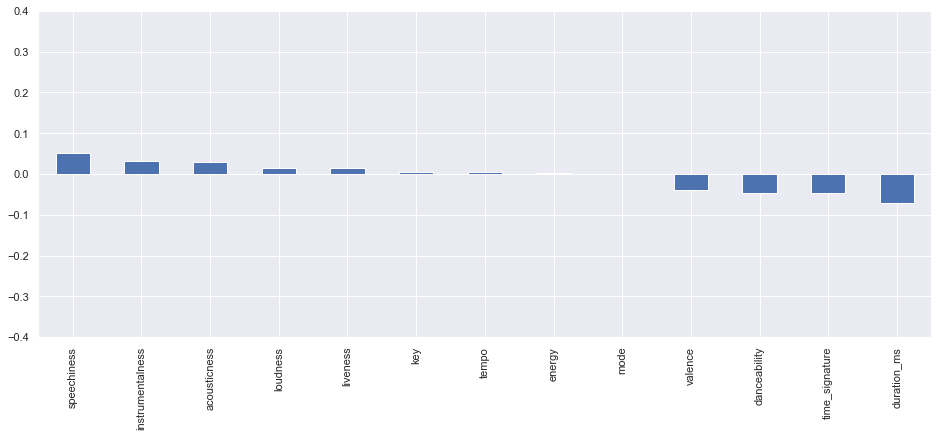

In [49]:
# correlated with peak rank in Billboard Hot 100
corr_billboard_weeks['peak-rank'].sort_values(ascending=False)[1:-1].plot(kind='bar', figsize=(16,6))
title='Correlation of Peak Rank on Billboard Hot 100 vs Audio Features'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(-0.4, 0.4)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Popularity with Audio Features


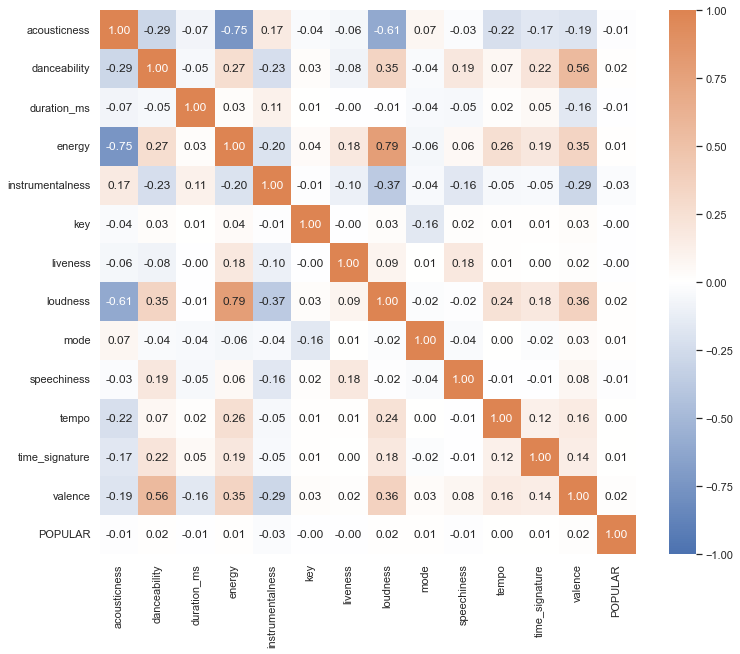

In [50]:
# correlation matrix - popular or not
# Note: "POPULAR" simply denotes whether or not a song appeared on the Billboard Hot 100
corr_popular = df_popularity.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_popular, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Popularity with Audio Features'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Popularity with Audio Features


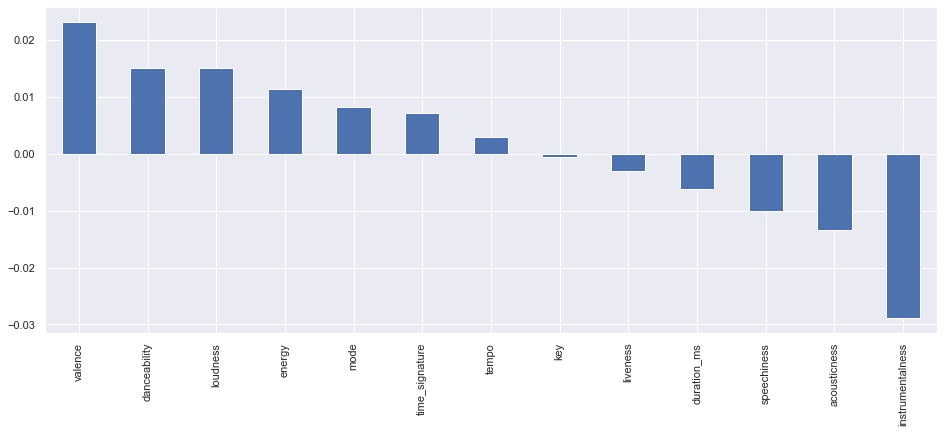

Correlation of Popularity with Audio Features (Full Scale)


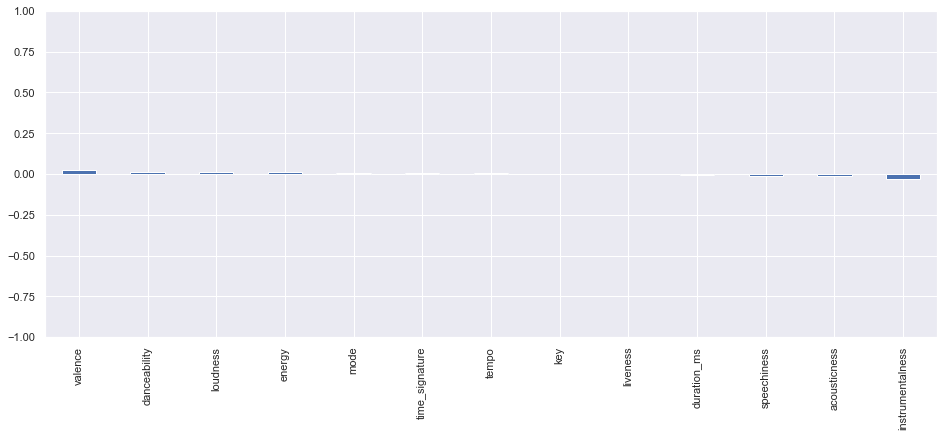

In [51]:
# correlated with peak rank in Billboard Hot 100
corr_popular['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

corr_popular['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features (Full Scale)'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(-1, 1)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

Correlation of Popularity with Audio Features, All Genres Combined


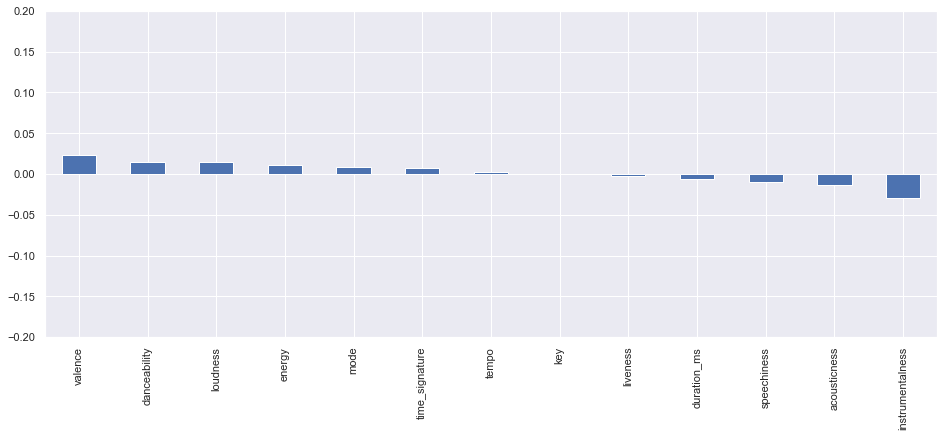

Correlation of Popularity with Audio Features, Filtered by Genre - Rock


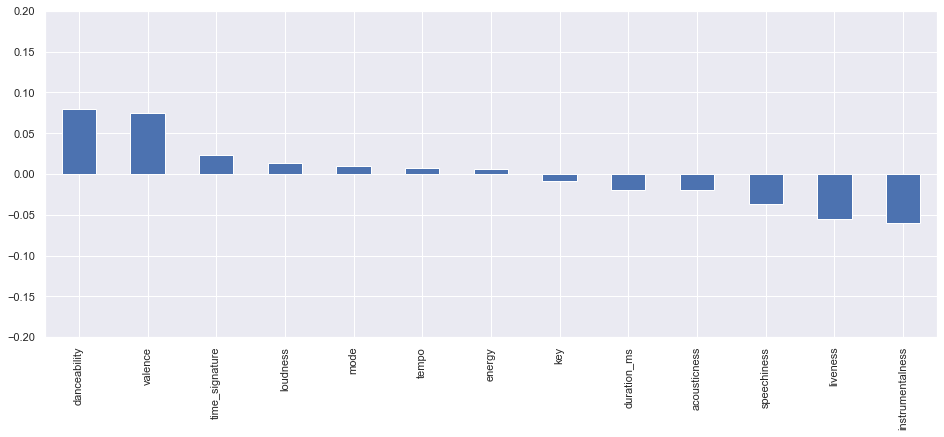

Correlation of Popularity with Audio Features, Filtered by Genre - Adult Standards


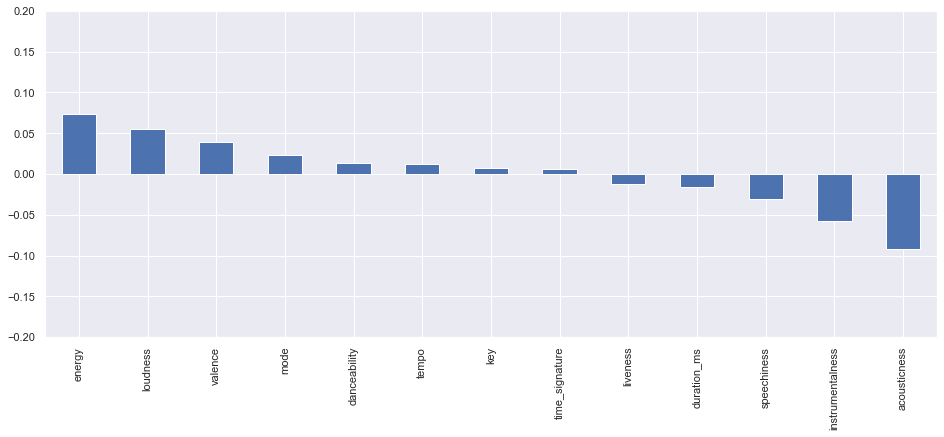

Correlation of Popularity with Audio Features, Filtered by Genre - Soul


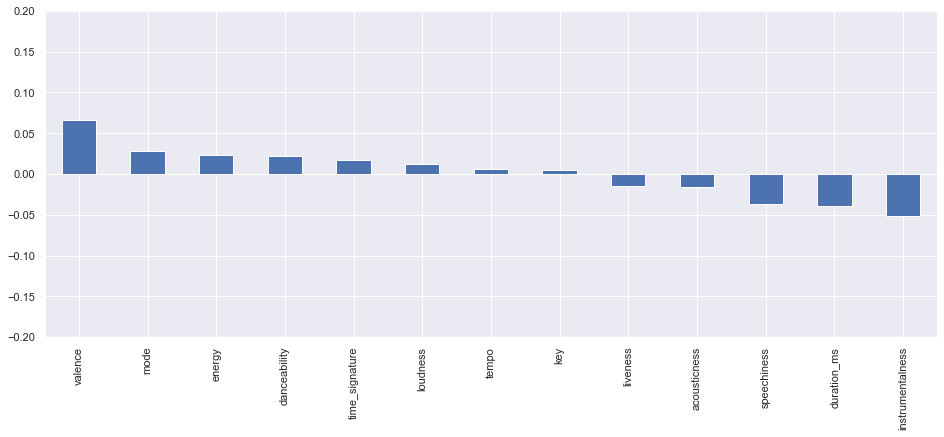

Correlation of Popularity with Audio Features, Filtered by Genre - Dance Pop


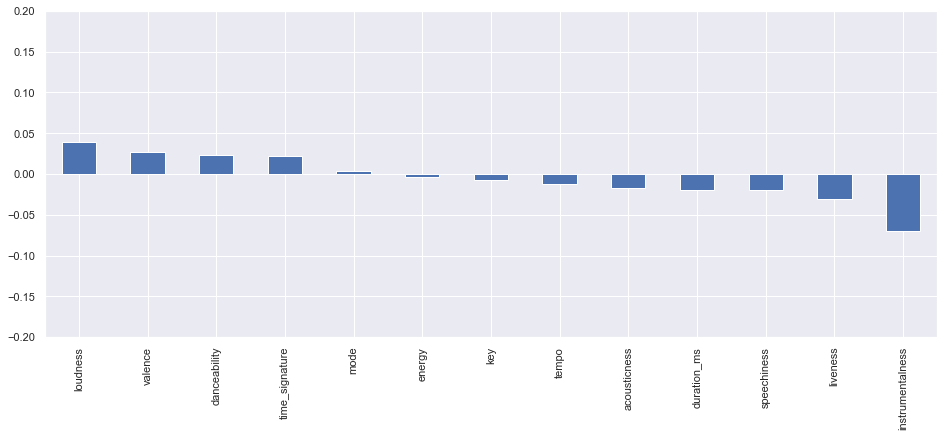

Correlation of Popularity with Audio Features, Filtered by Genre - Hip Hop


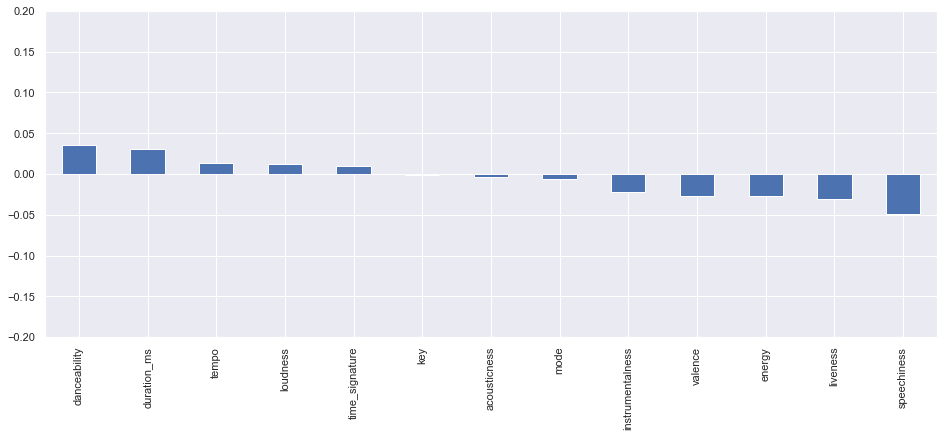

Correlation of Popularity with Audio Features, Filtered by Genre - Country


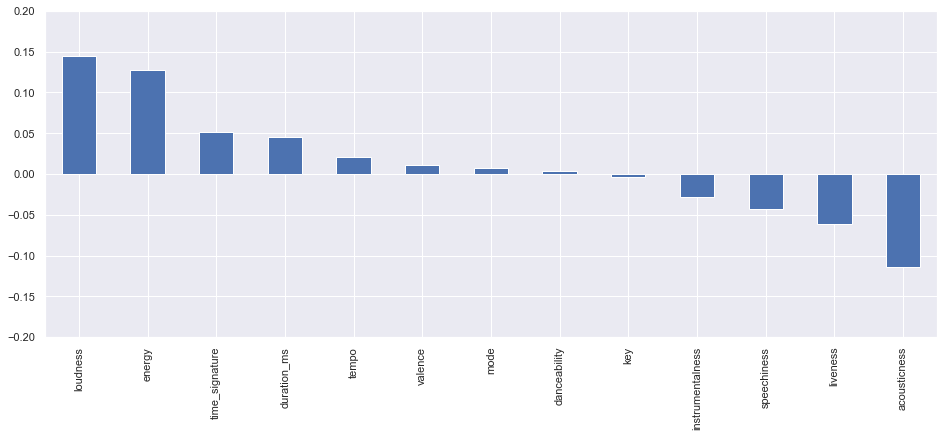

Correlation of Popularity with Audio Features, Filtered by Genre - Brill Building Pop


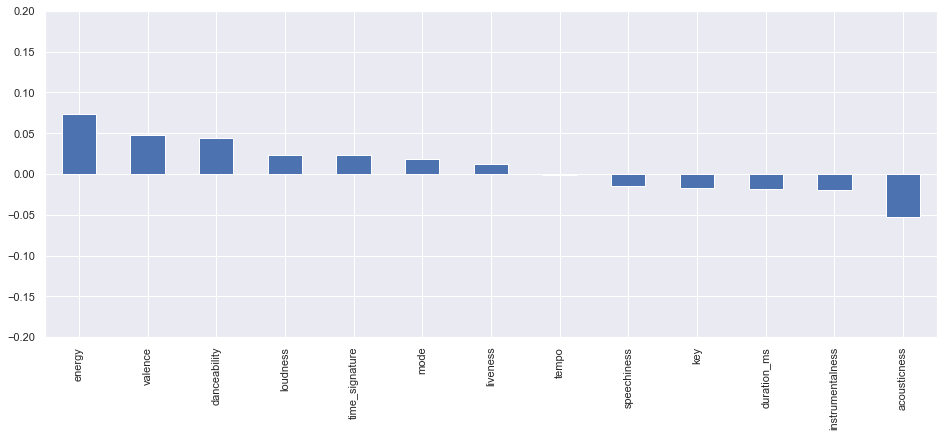

Correlation of Popularity with Audio Features, Filtered by Genre - Mellow Gold


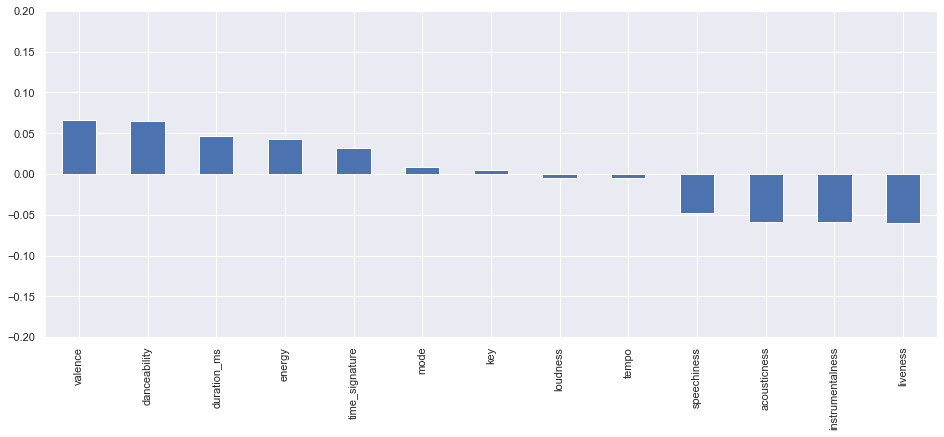

Correlation of Popularity with Audio Features, Filtered by Genre - Folk Rock


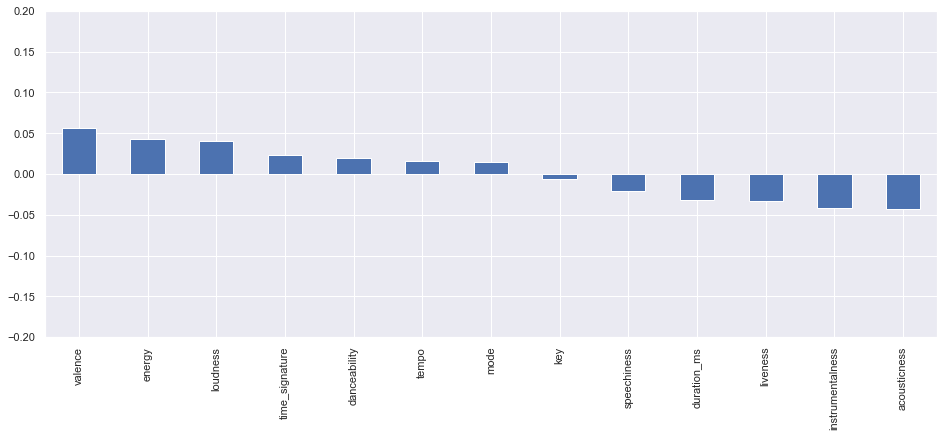

Correlation of Popularity with Audio Features, Filtered by Genre - Pop


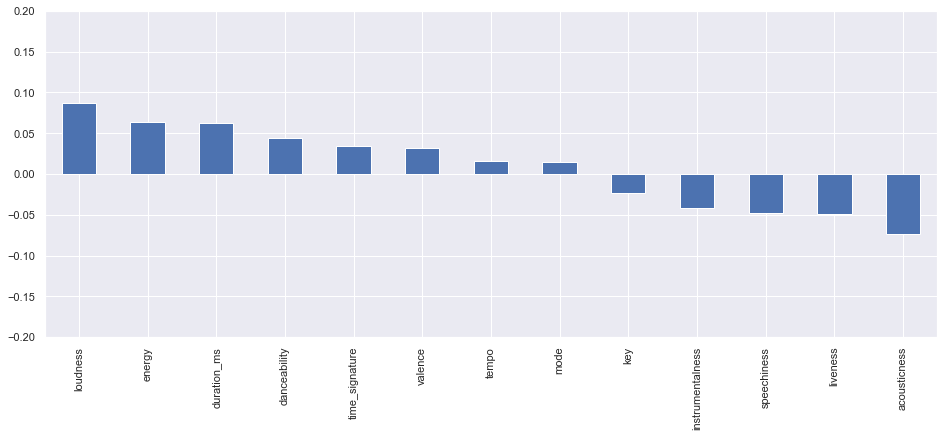

In [52]:
# top 10 genres in Billboard Hot 100
genres = list(df_B100_songs_genre.genre.value_counts().head(10).index)

# shared y limits
ylim = -0.2, 0.2

# all genres
df_popularity.corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features, All Genres Combined'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

# print the title
print(title)

plt.show()

# separated genres
for genre in genres:
    df_popularity.query(f'genre == "{genre}"').corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
    title = f'Correlation of Popularity with Audio Features, Filtered by Genre - {genre.title()}'
#     plt.title(title, fontsize=13, pad=20)
    plt.ylim(*ylim)

    # save the image
    plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)

    plt.show()

In [53]:
# testing with regex to look for ability to categorise more broadly

heavy_regex = df_popularity[df_popularity.genre.str.contains(r'(?:metal|heavy|hard|alternative)').fillna(False)]

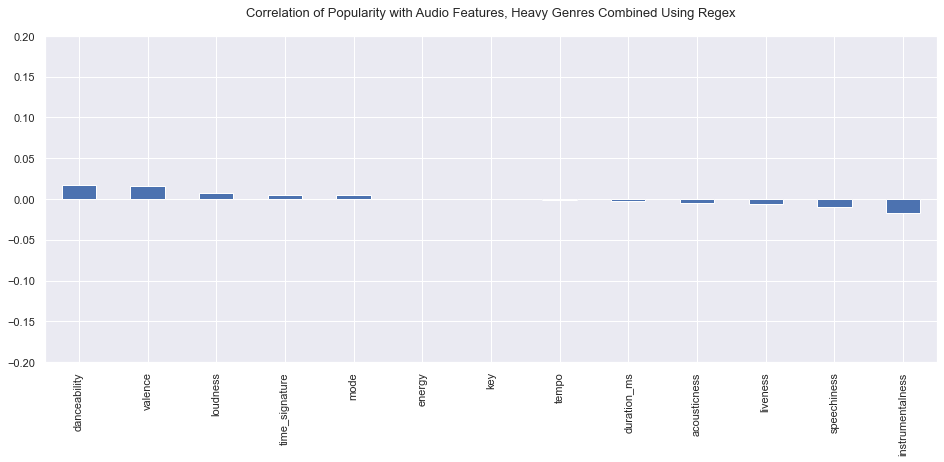

In [54]:
# shared y limits
ylim = -0.2, 0.2

# all genres
heavy_regex.corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features, Heavy Genres Combined Using Regex'
plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)
plt.show()

In [55]:
# there is some interesting stuff here!
heavy_regex.genre.sample(10)

2592639             alternative metal
3641186                         metal
1483120                 turkish metal
9325467           alternative hip hop
2550169    christian alternative rock
7884678        alternative roots rock
521233                 scottish metal
7451822           swedish heavy metal
3519520                 post-hardcore
1921771               alternative r&b
Name: genre, dtype: object

# Genres

### Import Genre Data

In [56]:
df_genre_counts.shape[0]

5489

In [57]:
# top 10 genres
df_genre_counts.head(10)

,count
genre,
classical,635467
classical performance,408792
adult standards,237596
orchestral performance,176051
rock,172423
early music,154337
orchestra,147577
vocal jazz,139082
folk rock,137774


In [58]:
# 10 random genres
list(df_genre_counts.sample(10).index)

['boston electronic',
 'jazz orchestra',
 'deep neo-synthpop',
 'new orleans rap',
 'swing revival',
 'mexican thrash metal',
 'zydeco',
 'viral rap',
 'emo',
 'canadian modern jazz']

### Too Many Genres!!!

* genre_id seems more like a subgenre than an overarching genre
* it may be worth grouping these subgenres into broader genres

### Regex Filtering to Create Subgenre Groups

##### Test Case 1: Heavy Music (not popular on Billboard Charts)

In [59]:
regex_heavy = r'(?:metal|heavy|hard|alternative)'

heavy_genre_counts = df_popularity[df_popularity.genre.str.contains(regex_heavy).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False)

In [60]:
# what about on the Billboard Hot 100?
df_B100_songs_genre[df_B100_songs_genre.genre.str.contains(regex_heavy).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head()

genre
alternative metal    131
alternative rock      36
hard rock             34
hardcore hip hop       9
glam metal             5
Name: id, dtype: int64

In [61]:
# alternative metal is most popular, let's take a look at the top 10 alt metal bands in the Billboard Hot 100
df_B100_songs_genre[df_B100_songs_genre.genre.str.contains('^alternative metal?')].groupby('artist').count()['id'].sort_values(ascending=False).head(10)

artist
Linkin Park          19
Nickelback           18
Three Days Grace      7
Shinedown             7
Good Charlotte        6
Breaking Benjamin     6
Seether               6
Papa Roach            6
Disturbed             6
System Of A Down      5
Name: id, dtype: int64

In [62]:
# let's compare to the heavy regex category
df_B100_songs_genre[df_B100_songs_genre.genre.str.contains(regex_heavy)].groupby('artist').count()['id'].sort_values(ascending=False).head(10)

# same bands, slightly different sorting

artist
Linkin Park              19
Nickelback               18
Red Hot Chili Peppers    12
Three Days Grace          7
Shinedown                 7
Breaking Benjamin         6
Disturbed                 6
Seether                   6
Papa Roach                6
Good Charlotte            6
Name: id, dtype: int64

In [63]:
# even though the top 10 is the same, many less popular bands are missed
(df_B100_songs_genre[df_B100_songs_genre.genre.str.contains('alternative metal')].groupby('artist').count()['id'].shape[0], 
df_B100_songs_genre[df_B100_songs_genre.genre.str.contains(regex_heavy)].groupby('artist').count()['id'].shape[0])

(34, 97)

In [64]:
# let's take a look - every heavy song on the Billboard charts that isn't "alternative metal"
df_B100_songs_genre[
    (df_B100_songs_genre.genre.str.contains(regex_heavy)) & (df_B100_songs_genre.genre != 'alternative metal')
].sort_values('release_date')[['artist', 'song', 'release_date', 'genre']]

# not a lot of data to work with, probably shouldn't use this genre
# lets see if this improves specificity for audio features

,artist,song,release_date,genre
6476,Gene Simmons,Radioactive,1978-01-01,hard rock
19110,Vandenberg,Burning Heart,1982-01-01,hard rock
6657,Giuffria,Call To The Heart,1984-01-01,hard rock
6659,Giuffria,Lonely In Love,1984-01-01,hard rock
6658,Giuffria,I Must Be Dreaming,1986-01-01,hard rock
19188,Vixen,Edge Of A Broken Heart,1988-01-01,glam metal
19187,Vixen,Cryin',1988-01-01,glam metal
15484,Stryper,Always There For You,1988-01-01,hard rock
15486,Stryper,I Believe In You,1988-01-01,hard rock
3975,Dan Reed Network,Ritual,1988-01-01,glam metal


### Boxplots

In [65]:
# helper function with variable number of dataframes would be useful to compare more data

def boxplot_genre_comparison(dataframe, genre_dict, title, figsize=(20,10), showfliers=False):

    boxplot_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
    plt.figure(figsize=figsize)

    list_of_genre_df = []
    
    for genre in genre_dict:
        list_of_genre_df.append(dataframe[dataframe.genre.str.contains(genre_dict[genre]).fillna(False)][boxplot_features].assign(genre_name=genre))
    
    sns.boxplot(pd.melt(pd.concat(list_of_genre_df), id_vars=['genre_name']), x='variable', y='value', hue='genre_name', showfliers=showfliers)
#     plt.title(title, fontsize=13, pad=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # save the figure
    plt.savefig(f'figures/genres/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    # print the title
    print(title)
    
    plt.show()


Comparison of Genrealised Genre with Top Subgenre - Heavy Music (Billboard Charts)


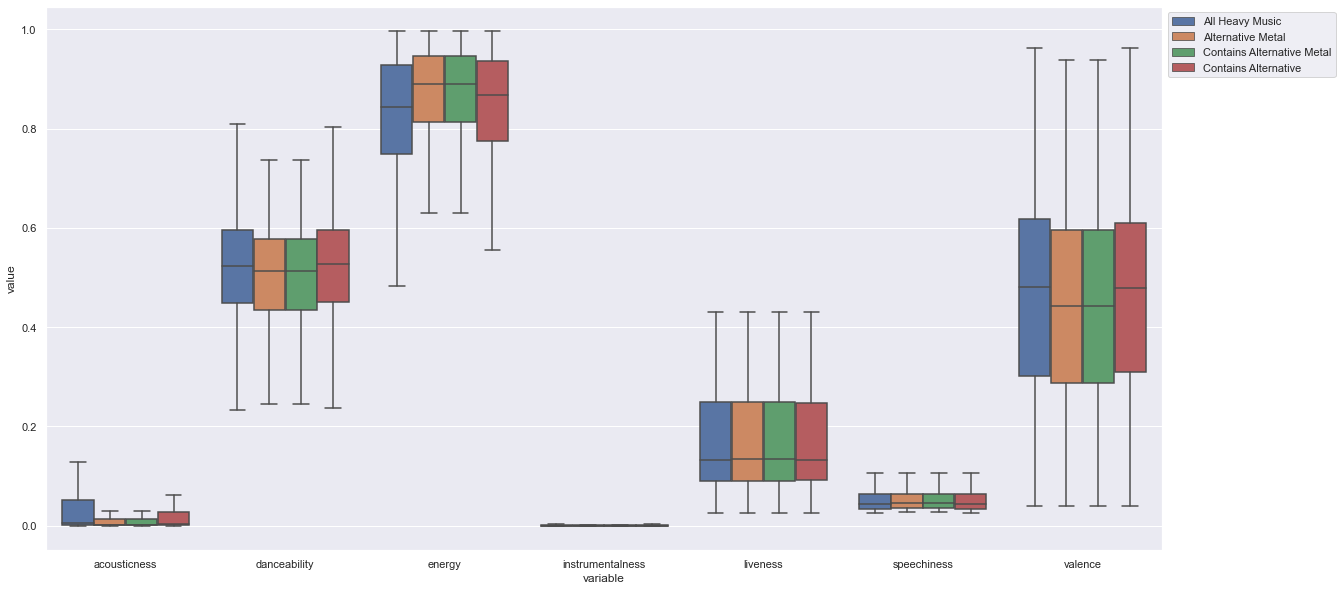

Comparison of Genrealised Genre with Top Subgenre - Heavy Music (All Songs)


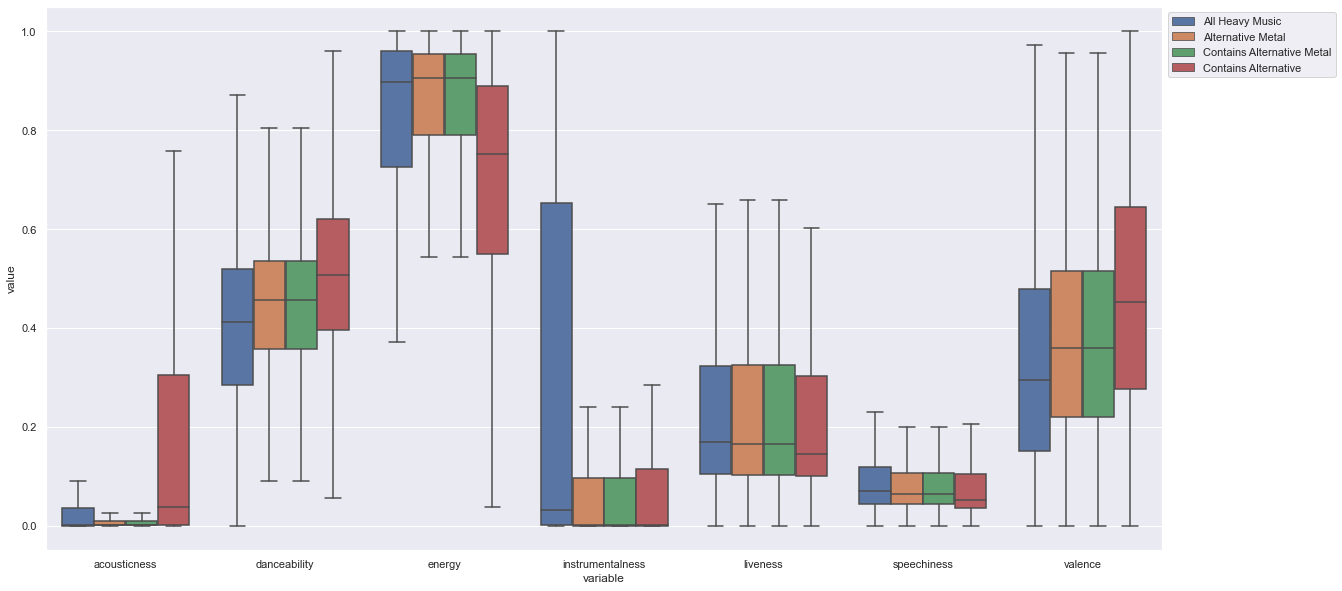

In [66]:
genre_dict = {
    'All Heavy Music': r'(?:metal|heavy|hard|alternative)', 
    'Alternative Metal': '^alternative metal?',
    'Contains Alternative Metal': 'alternative metal',
    'Contains Alternative': 'alternative',
}

title = 'Comparison of Genrealised Genre with Top Subgenre - Heavy Music ({})'

boxplot_genre_comparison(df_B100_songs_genre, genre_dict, title.format('Billboard Charts'))
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'))

##### Conclusion: It looks like adding more genrealised genre data increases variability

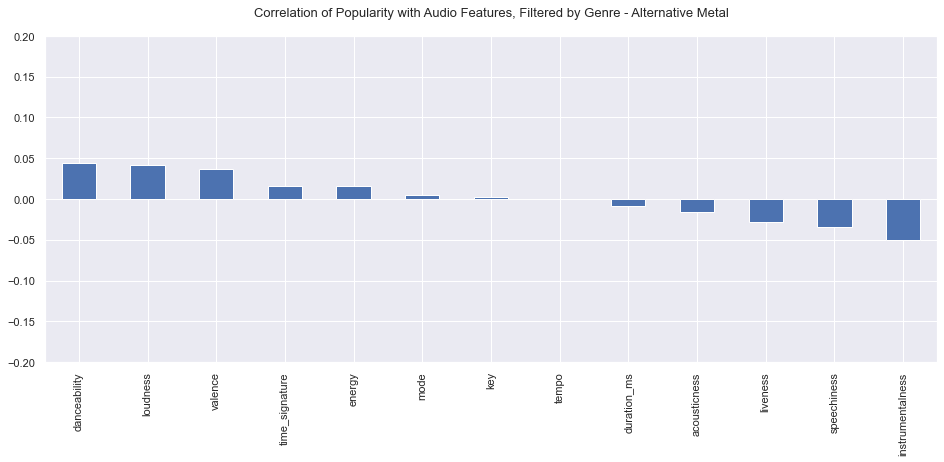

In [67]:
# let's see if "alternative metal is any better behaved than heavy music in general"

genre = 'alternative metal'

df_popularity.query(f'genre == "{genre}"').corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title = f'Correlation of Popularity with Audio Features, Filtered by Genre - {genre.title()}'
plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)

plt.show()

* This looks a little better, not as strong as some genres, and weak correlation overall
* It may be difficult to make any popularity predictions using these features for this genre
* Interesting non-intuitive results. Popular Alternative Metal is:
    * Billboard charts have more consistent songs (not surprising)
    * danceable
    * loud (not surprising)
    * happier than typically in the genre (positively correlated with higher valence)
    * lower instrumentalness correlated with higher "popularity" 

##### Test Case 2: Pop Music

In [68]:
regex_pop = r'(?:pop|adult standards|contemporary)'

# top 10 regex_pop genres (all songs)
df_popularity[df_popularity.genre.str.contains(regex_pop).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head(10)

genre
adult standards      166612
dance pop             29033
afropop               15853
c-pop                 15568
pop rock              15377
pop rap               14520
italian adult pop     14267
europop               13013
new wave pop          11763
russian pop           11404
Name: id, dtype: int64

In [69]:
# top 10 regex_pop genres (billboard)
df_B100_songs_genre[df_B100_songs_genre.genre.str.contains(regex_pop).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head(10)

genre
adult standards       2640
dance pop             1249
brill building pop     561
pop                    491
pop rock               327
new wave pop           273
bubblegum pop          241
post-teen pop          196
pop rap                178
urban contemporary     132
Name: id, dtype: int64

In [70]:
# confirming that "adult standards" are indeed Pop Music - looks like it to me!
df_B100_songs_genre.query('genre == "adult standards"').artist.sample(10)

2410              Brenda Lee
8132     Jay & The Americans
3152                 Chicago
10689                   Lobo
4845                Dr. Hook
6178          Frankie Avalon
16510           The Crystals
19276           Wayne Newton
14644          Sarah Vaughan
8455           Jimmy Clanton
Name: artist, dtype: object

Comparison of Pop Genre Groupings - Billboard Charts


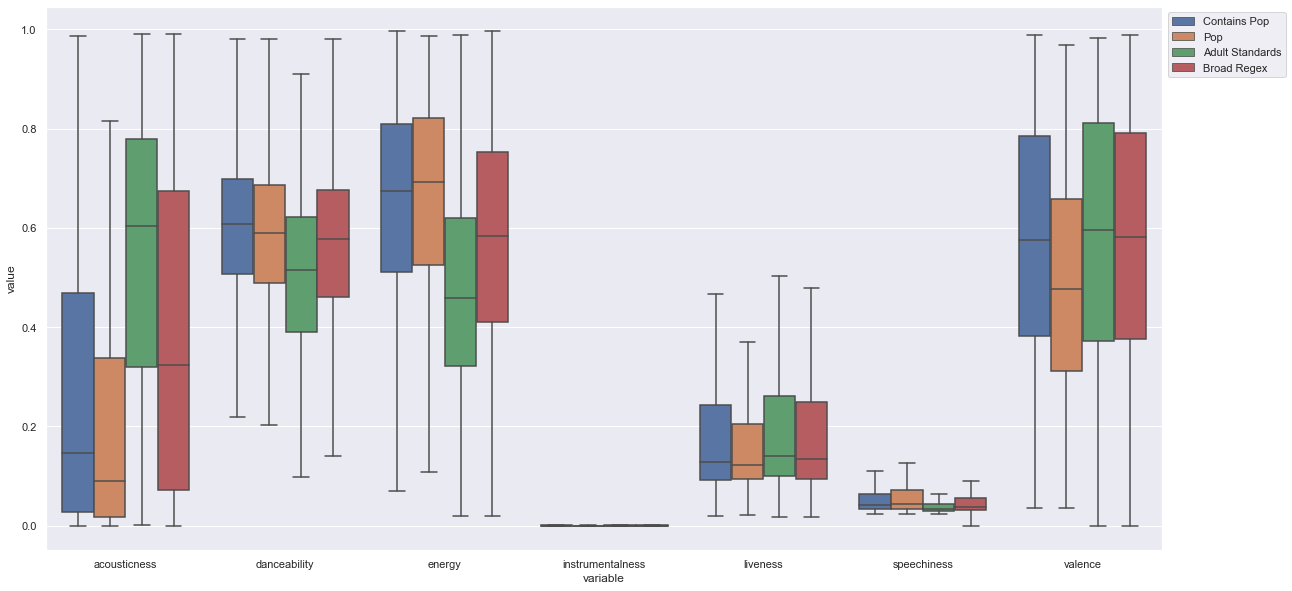

Comparison of Pop Genre Groupings - All Songs


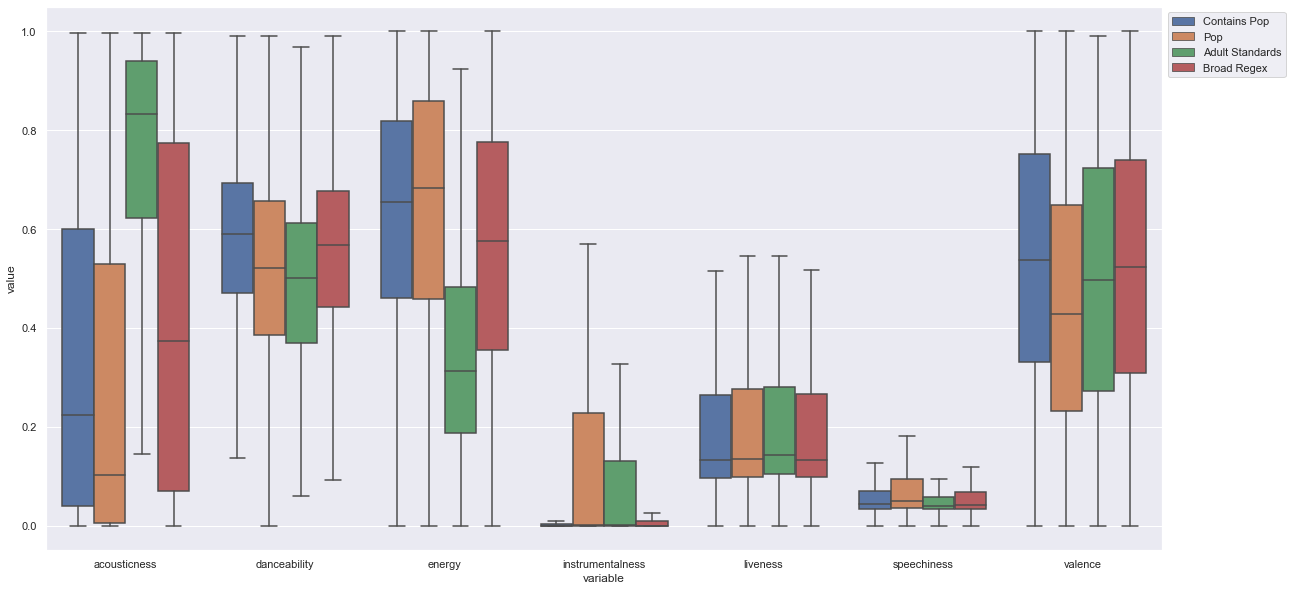

In [71]:
# boxplot comparison of Pop genres

genre_dict = {
    'Contains Pop': r'pop',
    'Pop': r'^pop?',
    'Adult Standards': r'^adult standards?',
    'Broad Regex':  r'(?:pop|adult standards|contemporary)'
}

title = 'Comparison of Pop Genre Groupings - {}'

boxplot_genre_comparison(df_B100_songs_genre, genre_dict, title.format('Billboard Charts'))
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'))

### Boxplots for Large Genre Groups

In [72]:
# df_B100_songs_genre.groupby('genre').count()['id'].sort_values(ascending=False).head(50)

In [73]:
# approximating genre categories
genre_dict = {
    'All Songs': r'.+', 
    'Adult Standards': r'(?:adult standards|mellow gold|soft rock|contemporary)',
    'Rock': r'(?:rock|^country|^soft)',
    'R&B':  r'(?:soul|rhythm and blues|motown|funk|disco|quiet storm)',  # this one is a stretch
    'Country': r'(?:country|folk|nashville sound)',
    'Pop': r'\b(?:pop|europop)\b',  # whole word only
    'Rap': r'\b(?:rap|trap|hip hop)\b',  # whole word only
    'Alternative': r'(?:alternative)',  # not sure if grunge or punk should be here
    'EDM': r'(?:house|trance|techno|drum and bass|dubstep|synth|edm|breakbeat)', # not very popular on Bilboard
    'Metal': r'(?:heavy|metal|thrash|djent|deathcore|mathcore|grindcore)' # not very popular on Bilboard
}

Comparison of Audio Featuers for Large Genre Groupings (as defined by Kevin) - All Songs


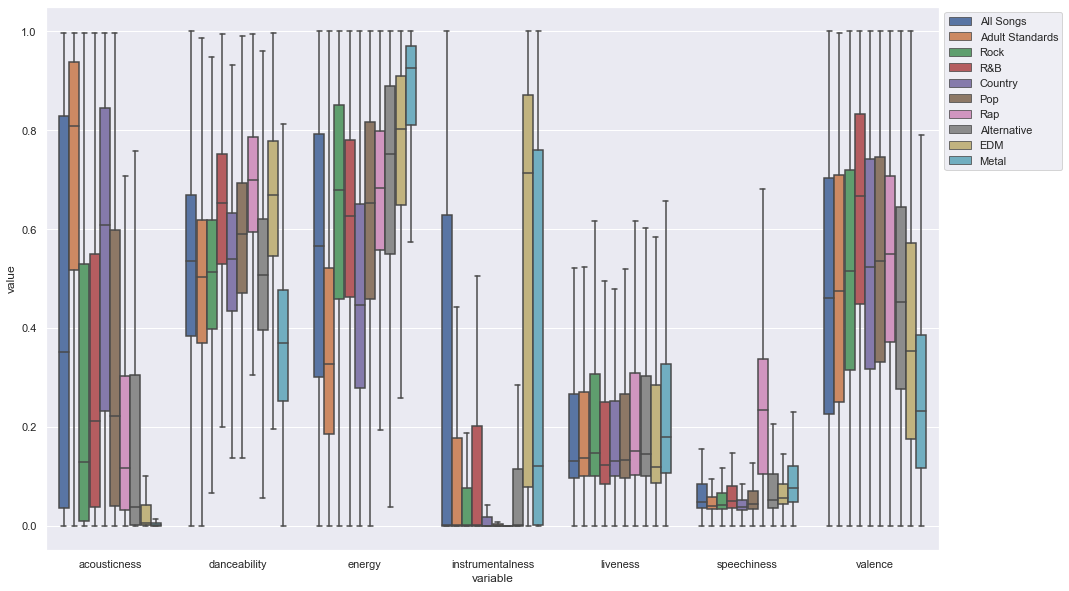

In [74]:
# plot it
title = 'Comparison of Audio Featuers for Large Genre Groupings (as defined by Kevin) - {}'
figsize = (16, 10)
# boxplot_genre_comparison(df_B100_songs_genre, genre_dict, title.format('Billboard Charts'), figsize=figsize)
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'), figsize=figsize)

In [75]:
# genre statistics vs relative popularity

df_genres = pd.DataFrame()

for genre in list(genre_dict.keys()):
    df_genres.loc[genre, 'billboard_counts'] = df_B100_songs_genre[(df_B100_songs_genre.genre.str.contains(genre_dict[genre])).fillna(False)].count()['id']
    df_genres.loc[genre, 'all_counts'] = df_10M[(df_10M.genre.str.contains(genre_dict[genre])).fillna(False)].count()['id']


In [76]:
# new columns
df_genres['proportion_billboard'] = df_genres['billboard_counts'] / df_genres['billboard_counts'].sum()
df_genres['proportion_allsongs'] = df_genres['all_counts'] / df_genres['all_counts'].sum()
df_genres['relative_popularity'] = df_genres['proportion_billboard'] / df_genres['proportion_allsongs']
df_genres['songs_per_popular_song'] = df_genres['all_counts'] / df_genres['billboard_counts']

# transpose and format
dft = df_genres.T
dft.iloc[0:2] = dft.iloc[0:2].applymap('{0:,.0f}'.format)
dft.iloc[2:-1] = dft.iloc[2:-1].applymap('{0:,.3f}'.format)
dft.iloc[-1:] = dft.iloc[-1:].applymap('{0:,.0f}'.format)
dft

,All Songs,Adult Standards,Rock,R&B,Country,Pop,Rap,Alternative,EDM,Metal
billboard_counts,"19,750","3,680","6,321","2,981","2,449","3,908","2,087",177,104,142
all_counts,"6,320,843","214,324","675,340","139,178","275,228","548,402","428,865","87,200","259,091","256,785"
proportion_billboard,0.475,0.088,0.152,0.072,0.059,0.094,0.050,0.004,0.003,0.003
proportion_allsongs,0.687,0.023,0.073,0.015,0.030,0.060,0.047,0.009,0.028,0.028
relative_popularity,0.691,3.800,2.071,4.740,1.969,1.577,1.077,0.449,0.089,0.122
songs_per_popular_song,320,58,107,47,112,140,205,493,"2,491","1,808"


In [77]:
# best genres to write music in if you want onto the Billboad Hot 100
print('Total Songs in each Genre per Song on the Billboard Hot 100')
print(df_genres['songs_per_popular_song'].astype('int32').sort_values())

Total Songs in each Genre per Song on the Billboard Hot 100
R&B                  46
Adult Standards      58
Rock                106
Country             112
Pop                 140
Rap                 205
All Songs           320
Alternative         492
Metal              1808
EDM                2491
Name: songs_per_popular_song, dtype: int32
